#**1. Data Cleaning For Machine Learning**

##**1.1 Import Library**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import time
import sys
import warnings
import pickle
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline as Imbpipeline
from lightgbm import LGBMClassifier
from scipy.sparse import issparse
from scipy.stats import randint, uniform
from scipy.stats import wilcoxon
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, make_scorer, PrecisionRecallDisplay, recall_score, RocCurveDisplay
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRegressor

try:
  from optbinning import OptimalBinning
except ImportError:
  print("Library optbinning belum tersedia. Proses Install...")
  !{sys.executable} -m pip install optbinning
  from optbinning import OptimalBinning


##**1.2. Data Cleaning Berdasarkan Hasil EDA**

Sebelum masuk ke tahap pemodelan, dilakukan serangkaian proses pembersihan dan penyesuaian data. Tujuannya agar data yang digunakan benar-benar relevan, bersih, dan bebas dari inkonsistensi yang bisa mempengaruhi hasil model.

In [4]:
#1. Import Dataset From Kaggle dan Drop Baris Outlier
df = pd.read_excel('E Commerce Dataset.xlsx', "E Comm")
df = df.drop_duplicates()

#Upperbound NumberOfAddress
Q1_address = df['NumberOfAddress'].quantile(0.25)
Q3_address = df['NumberOfAddress'].quantile(0.75)
IQR_address = Q3_address - Q1_address
Upper_Bound_NumberOfAddress = Q3_address + 1.5 * IQR_address

#Upperbound dan Lowerbound CashbackAmount
Q1_cashback = df['CashbackAmount'].quantile(0.25)
Q3_cashback = df['CashbackAmount'].quantile(0.75)
IQR_cashback = Q3_cashback - Q1_cashback
Upper_Bound_CashbackAmount = Q3_cashback + 1.5 * IQR_cashback
Lower_Bound_CashbackAmount = Q1_cashback - 1.5 * IQR_cashback

#Filtering Row
df = df[~(df['WarehouseToHome']>40)]
df = df[~(df['HourSpendOnApp']>4)]
df = df[~((df['NumberOfAddress'] > Upper_Bound_NumberOfAddress) & (df['Churn'] == 0))]
df = df[~(df['DaySinceLastOrder']>29)]
df = df[~((df['CashbackAmount'] > Upper_Bound_CashbackAmount) & (df['Churn'] == 1))]
df = df[~((df['CashbackAmount'] < Lower_Bound_CashbackAmount) & (df['Churn'] == 0))]
df = df[~((df['NumberOfDeviceRegistered'] > 5) & (df['Churn'] == 0))]
df = df[~((df['NumberOfDeviceRegistered'] < 2) & (df['Churn'] == 1))]



#2. Penghapusan Kolom yang Tidak Relevan
df = df.drop('CustomerID', axis=1)


#4. Penyesuaian Variabel
df['SatisfactionScore'] = 6-df['SatisfactionScore'] #Perlu di-reverse karena fitur SatisfactionScore secara default menggunakan skala likert terbalik
fitur_kategori = list(df.select_dtypes(exclude='number').columns) + ['SatisfactionScore','CityTier','Complain']
for i in fitur_kategori:
  df[i] = df[i].astype('category')

#5. Perbaikan Nama Kategori
df['PreferredLoginDevice'] = df['PreferredLoginDevice'].replace('Mobile Phone', 'Phone')
df['PreferredPaymentMode'] = df['PreferredPaymentMode'].replace('COD', 'Cash on Delivery')
df['PreferredPaymentMode'] = df['PreferredPaymentMode'].replace('CC', 'Credit Card')

#6. Handling Missing Value :
#Iterative imputer dengan estimator XGBoostRegressor akan digunakan pada pipeline

#7. Handling Outlier pada Feature Numerik :

#8. Penentuan edge binning menggunakan library optbinning dan diterapkan pada pipeline


* **Duplikasi dan outlier dihapus** agar data bersih dan representatif untuk pemodelan.
* **`CustomerID`** dihapus karena tidak relevan untuk prediksi *churn*.
* **Skala `SatisfactionScore` dibalik** agar nilai tertinggi menunjukkan kepuasan paling baik.
* **Seluruh fitur kategori** dinormalisasi namanya dan diubah ke tipe `category`.
* **Nilai hilang** akan diimputasi dengan **Iterative Imputer** berbasis *estimator* pada *pipeline*.
* **Binning fitur numerik** menggunakan **optbinning** untuk menentukan batas bin yang optimal berdasarkan distribusi target (`churn`).
* **Binning diterapkan melalui pipeline** menggunakan *custom* *transformer* agar proses lebih efisien dan terhindar dari *data* *leakage*.
* Proses ini memastikan data siap untuk *modeling*, **meningkatkan interpretabilitas**, dan **mengurangi bias** akibat data tidak bersih.


##**1.3 Feature Engineering: Binning Menggunakan Optbinning**

Dalam proses *discretization* atau *binning* fitur numerik, digunakan pendekatan **optimal binning** yang disediakan oleh *library* `optbinning`. Metode ini dipilih karena memiliki keunggulan signifikan dibanding metode *binning* konvensional seperti `pandas.qcut` maupun `KBinsDiscretizer` dari scikit-learn.

Berbeda dari kedua metode tersebut, `optbinning` bersifat **supervised**, artinya proses penentuan batas bin mempertimbangkan hubungan antara fitur dengan target yang diprediksi (dalam hal ini, churn). Hal ini memungkinkan `optbinning` menghasilkan pembagian bin yang tidak hanya berdasarkan distribusi data, tetapi juga relevan secara prediktif.

Sementara `pandas.qcut` hanya membagi data berdasarkan kuantil dan `KBinsDiscretizer` bekerja berdasarkan strategi pembagian seperti uniform atau k-means, keduanya tidak memperhatikan nilai target dan cenderung bersifat statis. Selain itu, `optbinning` secara otomatis dapat menentukan jumlah bin yang optimal dan mendukung analisis lebih lanjut seperti **Weight of Evidence (WoE)** dan **Information Value (IV)** yang penting dalam interpretasi model.

1. **Weight of Evidence (WoE)**

  **Weight of Evidence (WoE)** merupakan suatu metode transformasi variabel yang digunakan untuk mengukur kekuatan suatu kategori atau interval dalam membedakan antara dua kelas target, khususnya pada model klasifikasi biner seperti prediksi *churn* (berhenti atau tidaknya pelanggan).

  **Rumus Perhitungan WoE:**

  $$
  \text{WoE}_i = \ln \left( \frac{\text{Distribusi Event}_i}{\text{Distribusi Non-Event}_i} \right)
  $$

  Dengan penjelasan sebagai berikut:

  * **Event** adalah jumlah observasi pada kelas target positif (misalnya churn = 1).
  * **Non-Event** adalah jumlah observasi pada kelas target negatif (misalnya `churn` = 0).
  * Distribusi dihitung berdasarkan proporsi jumlah *event* dan *non-event* pada setiap kelompok atau *bin* fitur.

  **Interpretasi WoE:**

  * WoE > 0 → kelompok tersebut lebih dominan berisi *event*.
  * WoE < 0 → kelompok tersebut lebih dominan berisi *non-event*.
  * WoE = 0 → tidak ada kekuatan pemisah terhadap target.

2. **Information Value (IV)**

  **Information Value (IV)** adalah ukuran statistik yang menggambarkan seberapa besar kontribusi suatu fitur dalam membedakan antara dua kelas target. Semakin tinggi nilai IV, semakin kuat fitur tersebut dalam memengaruhi prediksi model.

  **Rumus Perhitungan IV:**

  $$
  \text{IV} = \sum_i \left( \text{Distribusi Event}_i - \text{Distribusi Non-Event}_i \right) \times \text{WoE}_i
  $$

  **Interpretasi Nilai IV:**

  * **IV antara 0 hingga 0,1**
    → Fitur memiliki **kekuatan prediktif yang lemah**.

  * **IV antara 0,1 hingga 0,3**
    → Fitur tergolong **cukup informatif**.

  * **IV antara 0,3 hingga 0,5**
    → Fitur memiliki **kekuatan prediktif yang kuat**. Sangat berguna untuk memisahkan target.

  * **IV > 0,5**
    → Fitur **sangat kuat**, namun perlu **diwaspadai karena kemungkinan mengandung *data leakage*** (informasi target secara implisit atau eksplisit).


In [ ]:
# Menentukan Binning Edge, Nilai Max WOE dan IV pada Fitur Kategori
target = 'Churn'
fitur_numerik = list(df.select_dtypes(include='number').drop(columns=[target]).columns)

for kolom in fitur_numerik:
  binning = OptimalBinning(name=kolom, dtype="numerical", solver="cp")
  binning.fit(df[kolom], df[target])
  # Ambil dan modifikasi output table
  table = binning.binning_table.build()
  table = table.drop(columns=["Non-event", "Event","Count (%)","JS"], errors="ignore")
  print(f"========== Binning untuk {kolom} ==========")
  print(table)
  print('-'*72)

========== Binning untuk Tenure ==========
                   Bin  Count  Event rate       WoE        IV
0         (-inf, 0.50)    493    0.523327 -1.709859  0.399276
1         [0.50, 1.50)    678    0.514749 -1.675499  0.525166
2         [1.50, 4.50)    539    0.089054  0.708758  0.038774
3         [4.50, 7.50)    594    0.062290  1.095162  0.089087
4        [7.50, 15.50)   1562    0.056338  1.201913  0.271898
5       [15.50, 18.50)    364    0.038462  1.602391  0.098283
6         [18.50, inf)    970    0.032990  1.761529  0.300302
7              Special      0    0.000000       0.0  0.000000
8              Missing    262    0.301527 -0.776447  0.036598
Totals                   5462    0.165690            1.759384
------------------------------------------------------------------------
========== Binning untuk WarehouseToHome ==========
                   Bin  Count  Event rate       WoE        IV
0         (-inf, 6.50)    301    0.109635  0.477995  0.010682
1         [6.50, 8.50)    

##**1.4 Feature Selection: Klasifikasi Fitur Berdasarkan Risiko Data Leakage**

Dalam proses evaluasi fitur, dilakukan analisis terhadap nilai *Information Value (IV)* dan *Weight of Evidence (WoE)* untuk mengidentifikasi potensi risiko *data leakage*. Kriteria yang digunakan dalam klasifikasi ini adalah sebagai berikut:

1. **Fitur Tidak Aman**
   Fitur dikategorikan tidak aman apabila memiliki **nilai IV > 0.5**, yang menandakan bahwa fitur tersebut terlalu informatif dan berpotensi membawa informasi dari label (*target leakage*). Hal ini dapat menyebabkan model *overfitting* dan performa yang tidak realistis saat diterapkan ke data baru.

   “*An IV value above 0.5 indicates the predictor is suspiciously strong and should be checked for data leakage*.” Siddiqi, N. (2006). Credit Risk Scorecards

2. **Fitur Berisiko**
   Fitur dikategorikan berisiko apabila terdapat setidaknya satu binning dengan nilai **|WoE| > 1.5**. Nilai WoE yang sangat tinggi atau sangat rendah menunjukkan distribusi target yang ekstrem, yang dapat disebabkan oleh relasi tidak wajar atau adanya sinyal tersembunyi dari label.

   "*If WoE is too high (e.g., > 1.5), this may indicate the variable is capturing information that is unusually aligned with the target — it may be a case of leakage or overfitting*."Anik Chakraborty (Medium Article)

3. **Fitur Aman**
   Fitur dianggap aman apabila memiliki **nilai IV ≤ 0.5** dan **semua nilai WoE berada dalam rentang ±1.5**. Fitur-fitur dalam kategori ini umumnya stabil dan tidak menunjukkan indikasi *data leakage*.

---

### **Hasil Klasifikasi Fitur**

Berdasarkan analisis terhadap hasil binning, fitur-fitur dalam dataset diklasifikasikan sebagai berikut:

* **Fitur Tidak Aman**:

  * `Tenure`
    Memiliki nilai IV sebesar 1.759 yang sangat tinggi, serta WoE ekstrem pada beberapa bin, menandakan potensi kuat terjadinya *target leakage*.

* **Fitur Berisiko**:

  * `CashbackAmount`
    Memiliki bin dengan WoE sebesar +1.99, yang menunjukkan distribusi target sangat timpang.
  * `CouponUsed`
    Memiliki WoE sebesar +2.09 pada bin "Missing", yang mengindikasikan ketidakseimbangan informasi dan perlu dicurigai sebagai fitur yang berisiko *leakage*.

* **Fitur Aman**:

  * `WarehouseToHome`
  * `HourSpendOnApp`
  * `NumberOfDeviceRegistered`
  * `NumberOfAddress`
  * `OrderAmountHikeFromlastYear`
  * `OrderCount`
  * `DaySinceLastOrder`
  
  Ketujuh fitur tersebut menunjukkan nilai IV dalam rentang yang wajar dan tidak memiliki WoE ekstrem, sehingga dapat digunakan secara aman dalam pemodelan prediktif.


In [ ]:
# Menentukan Nilai Max WOE dan IV pada Fitur Kategori yang terindikasi leakage yaitu Complain dan Satisfactionscore
target = 'Churn'
fitur_kategori = ['Complain','SatisfactionScore']
result = []

for kolom in fitur_kategori:
  binning = OptimalBinning(name=kolom, dtype="categorical", solver="cp")
  binning.fit(df[kolom], df[target])
  # Ambil dan modifikasi output table
  table = binning.binning_table.build()
  table = table.drop(columns=["Non-event", "Event","Count (%)","JS"], errors="ignore")
  print(f"========== Binning untuk {kolom} ==========")
  print(table)
  print('-'*72)

========== Binning untuk Complain ==========
            Bin  Count  Event rate       WoE        IV
0           [0]   3908    0.107728  0.497679  0.149305
1           [1]   1554    0.311454 -0.823156  0.246949
2       Special      0    0.000000       0.0  0.000000
3       Missing      0    0.000000       0.0  0.000000
Totals            5462    0.165690            0.396255
------------------------------------------------------------------------
========== Binning untuk SatisfactionScore ==========
            Bin  Count  Event rate       WoE        IV
0           [5]   1124    0.116548  0.409048  0.029924
1           [4]    572    0.125874  0.321457  0.009696
2           [2]   1046    0.163480  0.016075  0.000049
3           [3]   1648    0.169296 -0.025861  0.000204
4           [1]   1072    0.235075  -0.43661  0.043010
5       Special      0    0.000000       0.0  0.000000
6       Missing      0    0.000000       0.0  0.000000
Totals            5462    0.165690            0.082883
---

##**1.5 Feature Selection: Evaluasi Potensi Data Leakage pada Fitur Kategorikal**

Berdasarkan hasil evaluasi terhadap **fitur `Complain`, diperoleh nilai IV sebesar 0,396** dengan nilai **WoE yang berada dalam rentang –0,823 hingga 0,497**. Meskipun IV menunjukkan kekuatan prediktif yang cukup kuat, nilainya masih berada di bawah ambang batas 0,5 dan tidak ditemukan WoE ekstrem dalam binning-nya. Dengan demikian, fitur ini dinilai aman untuk digunakan dalam proses pemodelan.

Sementara itu, fitur **`SatisfactionScore` memiliki nilai IV sebesar 0,082**, yang mengindikasikan kekuatan prediktif yang lemah hingga sedang. Seluruh nilai **WoE-nya juga berada dalam rentang yang wajar, yaitu antara –0,436 hingga 0,409**. Tidak terdapat bin dengan distribusi target yang ekstrem, dan tidak ditemukan nilai hilang maupun kategori khusus yang mengganggu keseimbangan informasi.

Berdasarkan hasil tersebut, baik **fitur `Complain` maupun `SatisfactionScore` dikategorikan sebagai fitur yang aman**. Keduanya tidak menunjukkan indikasi adanya kebocoran data dan dapat digunakan dalam model prediktif secara stabil dan andal.


##**1.6 Desain Skenario Pemodelan**

Untuk mengevaluasi dampak fitur terhadap performa model dan potensi kebocoran data (*data* *leakage*), proses pemodelan dilakukan dalam tiga skenario berikut:

1. **Skenario 1: Tanpa *Drop* Fitur (Baseline)**

   * Semua fitur digunakan sebagaimana adanya, tanpa ada penghapusan fitur yang terindikasi tidak aman atau berisiko kebocoran.
   * Tujuan: Menyediakan *baseline* performa maksimum yang bisa dicapai model jika tidak mempertimbangkan potensi kebocoran data.

2. **Skenario 2: *Drop* Fitur Tidak Aman**

   * Fitur-fitur yang diketahui secara eksplisit mengandung informasi target (*leakage* langsung), seperti data yang hanya tersedia setelah churn terjadi, dihapus dari pemodelan.
   * Tujuan: Meningkatkan validitas model dengan menghindari *overfitting* terhadap sinyal target yang tidak tersedia saat prediksi nyata dilakukan.

3. **Skenario 3: *Drop* Fitur Tidak Aman dan Berisiko**

   * Selain fitur tidak aman, juga dihapus fitur-fitur yang secara statistik teridentifikasi berisiko tinggi, seperti fitur dengan bin WoE ekstrem (|WoE| > 1.5) yang dapat menandakan distribusi target yang tidak wajar.
   * Tujuan: Membangun model yang tidak hanya bebas dari *data leakage*, tetapi juga lebih *generalizable* dan stabil terhadap variasi data.


#**2. Machine Learning untuk Skenario 1: Menyertakan Semua Fitur**

##**2.1. Preprocessing Skenario 1: Menyertakan Semua Fitur**

In [ ]:
df['Complain']=df['Complain'].astype('int')
X = df.drop('Churn', axis=1)
y = df['Churn']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020, stratify=y)

Pada tahap awal, kolom `Complain` diubah ke tipe data integer untuk memastikan konsistensi pemrosesan data. Data kemudian dipisahkan menjadi fitur (**X**) dan target (**y**), lalu dibagi menjadi data training dan testing dengan proporsi 80:20. Pembagian data ini menggunakan parameter **stratify** pada variabel target, sehingga proporsi kelas **Churn** pada data training dan testing tetap seimbang. Penggunaan stratifikasi ini penting untuk mencegah bias akibat ketidakseimbangan kelas selama proses pemodelan, sehingga hasil evaluasi model menjadi lebih representatif.

In [ ]:
class OptBinningTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, splits):
        self.splits = splits

    def fit(self, X, y=None):
        # Sudah fit splits di luar
        return self

    def transform(self, X):
        X_ = np.asarray(X)
        if X_.ndim == 1:
            X_ = X_.reshape(-1, 1)
        vals = X_[:, 0]
        return np.digitize(vals, bins=self.splits).reshape(-1, 1)


Class **OptBinningTransformer** dibuat agar proses *binning* hasil **OptBinning** bisa dimasukkan ke dalam pipeline dan tetap dapat di-save (pickle) tanpa error.
Dengan class ini, aturan *binning* yang sudah di-*fit* pada data training bisa digunakan ulang secara konsisten, sekaligus memastikan *pipeline* bisa disimpan dan di-*load* kembali untuk *deployment*.

In [ ]:
impute_cols = [
    'Tenure', 'OrderAmountHikeFromlastYear', 'CouponUsed',
    'OrderCount', 'DaySinceLastOrder'
]

binning_cols = [
    'Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered',
    'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed',
    'OrderCount', 'DaySinceLastOrder', 'CashbackAmount'
]

categorical_cols = [
    'PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus'
]
ordinal_cols = ['CityTier', 'SatisfactionScore']

num_transformers = []

for col in binning_cols:
    steps = []
    # Jika butuh imputasi
    if col in impute_cols:
        imputer = IterativeImputer(
            estimator=XGBRegressor(n_estimators=100, max_depth=3, verbosity=0, random_state=42),
            max_iter=10, random_state=0
        )
        # Fit dulu untuk dapetin data imputasi training
        imputed_train_col = imputer.fit_transform(x_train[[col]])
        train_col_data = pd.Series(imputed_train_col.ravel())
    else:
        train_col_data = x_train[col]
        imputer = None

    # Fit OptBinning hanya di training
    binning = OptimalBinning(name=col, dtype="numerical")
    binning.fit(train_col_data.values, y_train)
    splits = binning.splits

    # Siapkan pipeline steps
    if imputer is not None:
        steps.append(('imputer', imputer))
    steps.append(('binning', OptBinningTransformer(splits)))
    col_pipe = Pipeline(steps)
    num_transformers.append((f'{col}_pipe', col_pipe, [col]))

cat_transformer = ('cat_ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols)
ord_transformer = ('ord_enc', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_cols)

transformer = ColumnTransformer(
    transformers=num_transformers + [cat_transformer, ord_transformer],
    remainder='passthrough'
)

transformer.fit(x_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('Tenure_pipe',
                                 Pipeline(steps=[('imputer',
                                                  IterativeImputer(estimator=XGBRegressor(base_score=None,
                                                                                          booster=None,
                                                                                          callbacks=None,
                                                                                          colsample_bylevel=None,
                                                                                          colsample_bynode=None,
                                                                                          colsample_bytree=None,
                                                                                          device=None,
                                                                                          early_stopping_rounds=None,
                                                                                          enable_categorical=False,
                                                                                          eval_metric=None,
                                                                                          feature_types=None,
                                                                                          g...
                                                  OptBinningTransformer(splits=array([124.39500046, 129.63000488, 149.73999786, 154.63000488,
       162.43499756, 229.89000702])))]),
                                 ['CashbackAmount']),
                                ('cat_ohe',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['PreferredLoginDevice',
                                  'PreferredPaymentMode', 'Gender',
                                  'PreferedOrderCat', 'MaritalStatus']),
                                ('ord_enc',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['CityTier', 'SatisfactionScore'])])

**Breakdown Pipeline Data Preprocessing**

**1. Data Preparation**

Sebelum dilakukan pemodelan, data dipersiapkan dengan memastikan tipe data pada kolom `Complain` dan `Churn` bertipe integer. Selanjutnya, data dibagi menjadi data fitur (`X`) dan target (`y`), lalu dilakukan pemisahan menjadi data training dan testing dengan metode stratified split. Stratifikasi memastikan proporsi data *churn* tetap seimbang pada *train* dan *test* *set*.

**2. Identifikasi dan Klasifikasi Fitur**

Seluruh fitur pada dataset dikelompokkan berdasarkan tipe dan perlakuan *pre-processing* sebagai berikut:

* **Fitur Imputasi**: Fitur numerik yang berpotensi memiliki nilai hilang, seperti `Tenure`, `OrderAmountHikeFromlastYear`, `CouponUsed`, `OrderCount`, dan `DaySinceLastOrder`.
* **Fitur Binning**: Seluruh fitur numerik yang akan diubah ke bentuk kategori ordinal menggunakan metode **Optimal Binning**, untuk meningkatkan stabilitas dan interpretabilitas model.
* **Fitur Kategorikal**: Fitur non-numerik seperti `PreferredLoginDevice`, `PreferredPaymentMode`, `Gender`, `PreferedOrderCat`, dan `MaritalStatus`, yang akan diproses dengan **One-Hot Encoding**.
* **Fitur Ordinal**: Fitur dengan skala urutan seperti `CityTier` dan `SatisfactionScore`, yang akan diproses dengan **Ordinal Encoding**.

**3. Pipeline Numerik (Binning dan Imputasi)**

Setiap fitur numerik diproses melalui pipeline khusus:

* Jika fitur tersebut masuk dalam fitur imputasi, maka akan dilakukan **imputasi nilai hilang** menggunakan metode **Iterative Imputer** dengan estimator XGBoostRegressor, yang mampu menangani *missing value* secara lebih akurat.
* Selanjutnya, pada semua fitur numerik (baik yang diimputasi maupun tidak), dilakukan **Optimal Binning** pada **data training** untuk mendapatkan batas (*cut-off*) kategori bin yang optimal terhadap target (`Churn`).
* Binning dilakukan menggunakan *transformer* khusus (`OptBinningTransformer`) sehingga hasil binning konsisten dan pipeline tetap dapat di-*serialize* (pickle) untuk *deployment*.

**4. Pipeline Kategorikal dan Ordinal**

* **Fitur kategorikal** diubah menjadi representasi numerik dengan **One-Hot Encoding** agar dapat digunakan oleh algoritma *machine learning.*
* **Fitur ordinal** diproses menggunakan **Ordinal Encoder** dengan penanganan nilai unknown, menjaga urutan kategori secara konsisten.

**5. Gabungan Pipeline (ColumnTransformer)**

Seluruh pre-processing pada fitur numerik, kategorikal, dan ordinal digabungkan dalam satu pipeline utama menggunakan **ColumnTransformer**.
Fitur-fitur yang tidak termasuk dalam ketiga kelompok tersebut akan *dipassthrough*, yaitu diteruskan ke model tanpa perubahan.



##**2.2. Modelling Skenario 1: Menyertakan Semua Feature**

Dalam pengembangan model prediksi pada permasalahan klasifikasi, khususnya pada prediksi *customer churn*, digunakan beberapa algoritma berbasis pohon keputusan (decision tree-based models). Masing-masing algoritma memiliki cara kerja dan karakteristik tersendiri, sebagaimana dijelaskan berikut ini:

1. Decision Tree

  Algoritma **Decision Tree** bekerja dengan membagi data ke dalam cabang-cabang berdasarkan nilai fitur yang memberikan pemisahan terbaik antara kelas target. Proses ini dilakukan secara rekursif hingga terbentuk struktur pohon, dengan setiap simpul (node) merepresentasikan kondisi logika tertentu. Tujuan utamanya adalah meminimalkan ketidakteraturan (*impurity*) dalam kelompok data yang terbentuk. Model ini mudah dipahami dan diinterpretasikan, namun rentan terhadap overfitting, terutama jika pohon tumbuh terlalu dalam tanpa dilakukan pemangkasan (*pruning*).

2. Random Forest

  **Random Forest** merupakan pengembangan dari Decision Tree yang menggabungkan banyak pohon keputusan secara paralel menggunakan pendekatan *bagging* (*bootstrap aggregating*). Setiap pohon dilatih pada subset data dan subset fitur yang dipilih secara acak. Hasil akhir ditentukan berdasarkan suara terbanyak (*voting*) dalam klasifikasi atau rata-rata prediksi dalam regresi. Pendekatan ini meningkatkan akurasi dan stabilitas model, serta mengurangi risiko overfitting yang sering terjadi pada pohon tunggal.

3. AdaBoost (Adaptive Boosting)

  **AdaBoost** adalah teknik *ensemble boosting* yang membentuk model prediktif kuat dari gabungan beberapa model sederhana (*weak learners*), umumnya *decision stump* (pohon satu tingkat). Pada setiap iterasi, bobot data latih disesuaikan, sehingga model selanjutnya lebih menitikberatkan pada observasi yang sebelumnya salah klasifikasi. Model akhir merupakan kombinasi dari seluruh *weak learners* dengan bobot yang proporsional terhadap kinerjanya. Meskipun efektif pada data yang relatif bersih, AdaBoost cukup sensitif terhadap *outlier*.

4. Gradient Boosting

  **Gradient Boosting** juga merupakan teknik *boosting*, namun perbaikannya dilakukan dengan menyesuaikan kesalahan model sebelumnya berdasarkan turunan (*gradient*) dari fungsi kerugian (*loss function*). Setiap pohon baru dilatih untuk meminimalkan kesalahan prediksi yang masih tersisa. Model ini bersifat fleksibel karena memungkinkan penggunaan berbagai fungsi kerugian, serta umumnya memberikan performa yang baik, meskipun membutuhkan waktu pelatihan yang lebih lama dan rentan terhadap overfitting jika tidak ditangani dengan baik.

5. XGBoost (Extreme Gradient Boosting)

  **XGBoost** merupakan implementasi efisien dari Gradient Boosting yang dirancang untuk kecepatan dan performa yang tinggi. Algoritma ini memperkenalkan berbagai teknik optimisasi, seperti penanganan nilai hilang secara otomatis, serta paralelisasi proses pelatihan. XGBoost sangat populer pada kompetisi dan aplikasi industri karena kemampuannya dalam menghasilkan model yang akurat dan stabil, namun memerlukan pemilihan parameter (*hyperparameter tuning*) yang cermat.

6. LightGBM (Light Gradient Boosting Machine)

  **LightGBM** adalah algoritma boosting yang dikembangkan untuk efisiensi tinggi, terutama dalam menangani dataset berskala besar. Model ini menggunakan pendekatan pertumbuhan pohon berbasis daun (*leaf-wise growth*) serta histogram binning untuk mempercepat proses pelatihan. Selain itu, LightGBM mampu menangani fitur kategorik secara langsung tanpa perlu dikodekan ke dalam bentuk numerik. Keunggulan utamanya adalah kecepatan dan skalabilitas, meskipun model ini juga rentan terhadap overfitting apabila tidak dilakukan penyetelan parameter yang tepat.

---


**Evaluasi Kinerja Model Menggunakan Cross-Validation**

Untuk membandingkan kinerja berbagai algoritma klasifikasi dalam memprediksi *churn* pelanggan, dilakukan evaluasi terhadap enam jenis model pembelajaran mesin berbasis pohon keputusan, yaitu:

1. **Decision Tree**
2. **Random Forest**
3. **XGBoost (Extreme Gradient Boosting)**
4. **AdaBoost (Adaptive Boosting)**
5. **Gradient Boosting**
6. **LightGBM (Light Gradient Boosting Machine)**

Setiap model dikonfigurasi dengan parameter yang sesuai untuk mengatasi ketidakseimbangan kelas (*class imbalance*) pada data pelatihan. Model Decision Tree, Random Forest, dan LightGBM diberikan parameter `class_weight='balanced'` untuk menyesuaikan bobot kelas secara otomatis. Model XGBoost menggunakan parameter `scale_pos_weight`, yang dihitung berdasarkan rasio antara jumlah kelas mayoritas dan minoritas. Sementara itu, model AdaBoost menggunakan Decision Tree berukuran kecil (maksimal dua tingkat) sebagai *base learner*, dan Gradient Boosting diterapkan dengan parameter standar.

1. Integrasi Model ke dalam Pipeline

  Setiap model dimasukkan ke dalam pipeline yang terdiri atas dua komponen utama:

  * **Transformasi data** menggunakan `ColumnTransformer` yang telah dijelaskan sebelumnya (termasuk imputasi, binning, dan encoding fitur),
  * **Algoritma klasifikasi** sesuai dengan model yang sedang dievaluasi.

2. Metode Cross-Validation

  Evaluasi dilakukan dengan menggunakan metode **cross-validation terstratifikasi** sebanyak lima lipatan (*5-fold stratified cross-validation*). Teknik ini membagi data pelatihan ke dalam lima subset secara proporsional terhadap distribusi kelas, kemudian melatih dan menguji model secara bergantian di setiap lipatan. Pendekatan ini digunakan untuk memperoleh estimasi performa yang lebih andal dan mengurangi potensi bias akibat pembagian data yang tidak merata.

3. Metrik Evaluasi

  Kinerja masing-masing model diukur menggunakan empat metrik utama berikut:

  * **Recall**: Mengukur kemampuan model dalam mengenali pelanggan yang benar-benar melakukan churn.
  * **F2-score**: Metrik utama yang diprioritaskan dalam evaluasi ini karena memberikan bobot lebih besar terhadap *recall* dibanding precision.
  * **ROC AUC (Receiver Operating Characteristic - Area Under Curve)**: Menggambarkan kemampuan model dalam membedakan kelas churn dan non-churn.
  * **Average Precision**: Mencerminkan keseimbangan antara precision dan recall pada berbagai ambang batas.

  Selain mencatat nilai rata-rata (*mean*), juga dicatat nilai **standar deviasi** dari masing-masing metrik untuk menggambarkan kestabilan performa model di seluruh lipatan *cross-validation*.

4. Pengukuran Waktu Eksekusi

  Untuk setiap model, dicatat pula durasi waktu yang dibutuhkan selama proses pelatihan dan evaluasi. Informasi ini penting dalam mempertimbangkan efisiensi komputasi serta kelayakan implementasi model dalam sistem produksi.


###**2.2.1 Fitting Model Dengan *Preprocessing Binning* (Tanpa *Resampling*)**

In [ ]:
# Definisi model
model1 = DecisionTreeClassifier(random_state=500, class_weight='balanced')
model2 = RandomForestClassifier(random_state=500, class_weight='balanced')
model3 = XGBClassifier(random_state=500, scale_pos_weight=np.sum(y_train==0)/np.sum(y_train==1), use_label_encoder=False, eval_metric='logloss')
model4 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2, random_state=500, class_weight='balanced'), random_state=500)
model5 = GradientBoostingClassifier(random_state=500)
model6 = LGBMClassifier(random_state=500, class_weight='balanced', verbose=-1)

# Daftar model dan nama
list_model = [model1, model2, model3, model4, model5, model6]
nama_model = ['Decision Tree', 'Random Forest', 'XGBoost', 'AdaBoost', 'Gradient Boosting', 'LightGBM']

# Cross-validation
kfold = StratifiedKFold(n_splits=5)
f2 = make_scorer(fbeta_score, beta=2)
list_scoring = ['recall', f2, 'roc_auc', 'average_precision']

# Evaluasi model
for i in range(len(list_model)):
    pipe_model = Imbpipeline([
        ('transformer', transformer),
        ('model', list_model[i])
    ])
    print(f'{nama_model[i]}')
    start_time = time.time()  # Mulai timer

    for scoring in list_scoring:
        cv_score = cross_val_score(estimator=pipe_model,
                                   X=x_train,
                                   y=y_train,
                                   cv=kfold,
                                   scoring=scoring)
        print(f'{scoring} score avg = {np.mean(cv_score):.3f}, std = {np.std(cv_score):.3f}')

    duration = time.time() - start_time  # Durasi training dan evaluasi
    print(f'Duration: {duration:.2f} seconds\n')

Decision Tree
recall score avg = 0.808, std = 0.028
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.809, std = 0.026
roc_auc score avg = 0.886, std = 0.016
average_precision score avg = 0.692, std = 0.044
Duration: 1.82 seconds

Random Forest
recall score avg = 0.743, std = 0.038
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.778, std = 0.032
roc_auc score avg = 0.985, std = 0.004
average_precision score avg = 0.945, std = 0.014
Duration: 10.67 seconds

XGBoost
recall score avg = 0.877, std = 0.032
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.879, std = 0.027
roc_auc score avg = 0.976, std = 0.003
average_precision score avg = 0.925, std = 0.016
Duration: 3.53 seconds

AdaBoost
recall score avg = 0.746, std = 0.018
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.685, std = 0.024
roc_auc score avg = 0.886, std = 0.016
average_precision score avg = 0.660, std = 0.057
Duration: 2.72

| Peringkat | Model             | F2-score | Durasi (s) |
| --------- | ----------------- | -------- | ---------- |
| 1         | **XGBoost**       | 0.879    | 3.53       |
| 2         | **LightGBM**      | 0.876    | 3.55       |
| 3         | Decision Tree     | 0.809    | 1.82       |
| 4         | Random Forest     | 0.778    | 10.67      |
| 5         | AdaBoost          | 0.685    | 2.72       |
| 6         | Gradient Boosting | 0.641    | 14.77      |


**Analisis Hasil Model**

Hasil evaluasi menunjukkan bahwa XGBoost dan LightGBM memberikan F2-score tertinggi dengan durasi training yang sangat efisien, masing-masing sekitar 3,5 detik. Keduanya menjadi pilihan terbaik untuk prediksi churn pada data ini. Model Decision Tree memang memiliki durasi training paling cepat, tetapi F2-score-nya jauh di bawah XGBoost dan LightGBM. Model lain seperti Random Forest, AdaBoost, dan Gradient Boosting memiliki F2-score lebih rendah dan durasi training yang lebih lama, sehingga kurang direkomendasikan.

### **2.2.2 Eksperimen *Fitting* Model Jika Tidak Dilakukan *Binning* Terlebih Dahulu**

In [ ]:
df['Complain']=df['Complain'].astype('int')
X = df.drop(['Churn'], axis=1)
y = df['Churn']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020, stratify=y)

# Kolom yang akan di-imputasi (sebelum binning)
impute_cols = [
    'Tenure',
    'OrderAmountHikeFromlastYear',
    'CouponUsed',
    'OrderCount',
    'DaySinceLastOrder',
    'WarehouseToHome',
    'HourSpendOnApp'
]

# Fitur kategorikal
categorical_cols = [
    'PreferredLoginDevice', 'PreferredPaymentMode',
    'Gender', 'PreferedOrderCat', 'MaritalStatus'
]

# Buat transformer numerikal (IterativeImputer)
xgboostreg = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, verbosity=0, n_jobs=-1, random_state=42)
imputer = IterativeImputer(estimator=xgboostreg, max_iter=10, random_state=0)
numerical_transformer0 = ('imputer', imputer, impute_cols)

# Buat transformer kategorikal (OneHotEncoder)
categorical_transformer0 = ('cat_ohe',
    OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
    categorical_cols
)

# Tambahkan fitur ordinal
ordinal_cols = ['CityTier', 'SatisfactionScore']
ordinal_transformer0 = ('ordinal_enc',
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    ordinal_cols
)

# Gabungkan semua ke ColumnTransformer
transformer0 = ColumnTransformer(
    transformers=[numerical_transformer0,categorical_transformer0,ordinal_transformer0],
    remainder='passthrough'
)

# Fit transformer ke data
transformer0.fit(x_train, y_train)

# Definisi model
model1 = DecisionTreeClassifier(random_state=500, class_weight='balanced')
model2 = RandomForestClassifier(random_state=500, class_weight='balanced')
model3 = XGBClassifier(random_state=500, scale_pos_weight=np.sum(y_train==0)/np.sum(y_train==1), use_label_encoder=False, eval_metric='logloss')
model4 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2, random_state=500, class_weight='balanced'), random_state=500)
model5 = GradientBoostingClassifier(random_state=500)
model6 = LGBMClassifier(random_state=500, class_weight='balanced', verbose=-1)

# Daftar model dan nama
list_model = [model1, model2, model3, model4, model5, model6]
nama_model = ['Decision Tree', 'Random Forest', 'XGBoost', 'AdaBoost', 'Gradient Boosting', 'LightGBM']

# Cross-validation
kfold = StratifiedKFold(n_splits=5)
f2 = make_scorer(fbeta_score, beta=2)
list_scoring = ['recall', f2, 'roc_auc', 'average_precision']

# Evaluasi model
for i in range(len(list_model)):
    pipe_model = Imbpipeline([
        ('transformer', transformer0),
        ('model', list_model[i])
    ])
    print(f'{nama_model[i]}')
    start_time = time.time()  # Mulai timer

    for scoring in list_scoring:
        cv_score = cross_val_score(estimator=pipe_model,
                                   X=x_train,
                                   y=y_train,
                                   cv=kfold,
                                   scoring=scoring)
        print(f'{scoring} score avg = {np.mean(cv_score):.3f}, std = {np.std(cv_score):.3f}')

    duration = time.time() - start_time  # Durasi training dan evaluasi
    print(f'Duration: {duration:.2f} seconds\n')

Decision Tree
recall score avg = 0.816, std = 0.025
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.816, std = 0.017
roc_auc score avg = 0.890, std = 0.010
average_precision score avg = 0.699, std = 0.030
Duration: 88.30 seconds

Random Forest
recall score avg = 0.749, std = 0.038
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.781, std = 0.032
roc_auc score avg = 0.984, std = 0.002
average_precision score avg = 0.943, std = 0.017
Duration: 98.60 seconds

XGBoost
recall score avg = 0.892, std = 0.024
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.892, std = 0.022
roc_auc score avg = 0.979, std = 0.003
average_precision score avg = 0.940, std = 0.013
Duration: 107.99 seconds

AdaBoost
recall score avg = 0.790, std = 0.038
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.706, std = 0.030
roc_auc score avg = 0.888, std = 0.015
average_precision score avg = 0.647, std = 0.023
Duration: 8

| Model             | F2-score Binning | Durasi (s) Binning | F2-score Tanpa Binning | Durasi (s) Tanpa Binning | Selisih F2 | Binning Lebih Cepat (x) |
|-------------------|------------------|--------------------|-----------------------|--------------------------|------------|-------------------------|
| XGBoost           | 0.879            | 3.53               | 0.892                 | 107.99                   | -0.013     | 30.6x                   |
| LightGBM          | 0.876            | 3.55               | 0.893                 | 91.71                    | -0.017     | 25.8x                   |
| Decision Tree     | 0.809            | 1.82               | 0.816                 | 88.30                    | -0.007     | 48.5x                   |
| Random Forest     | 0.778            | 10.67              | 0.781                 | 98.60                    | -0.003     | 9.2x                    |
| AdaBoost          | 0.685            | 2.72               | 0.706                 | 89.32                    | -0.021     | 32.8x                   |
| Gradient Boosting | 0.641            | 14.77              | 0.655                 | 106.43                   | -0.014     | 7.2x                    |


**Analisis Efisiensi Binning**

Penerapan binning membuat proses training semua model menjadi **jauh lebih cepat**—hingga 20–30 kali lipat—tanpa penurunan signifikan pada F2-score.
Model XGBoost dan LightGBM, misalnya, tetap mempertahankan F2-score tinggi (masing-masing 0.879 dan 0.876), sementara durasi training turun drastis dari sekitar 100 detik menjadi hanya 3–4 detik.
Dengan demikian, *binning* sangat efektif untuk meningkatkan efisiensi komputasi tanpa mengorbankan performa model.


### **2.2.3 Eksperimen Fitting Model dengan Preprocessing Binning yang disertai Resampling (SMOTE)**

In [ ]:
# Definisi model
model1 = DecisionTreeClassifier(random_state=500, class_weight='balanced')
model2 = RandomForestClassifier(random_state=500, class_weight='balanced')
model3 = XGBClassifier(random_state=500, scale_pos_weight=np.sum(y_train==0)/np.sum(y_train==1), use_label_encoder=False, eval_metric='logloss')
model4 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2, random_state=500, class_weight='balanced'), random_state=500)
model5 = GradientBoostingClassifier(random_state=500)
model6 = LGBMClassifier(random_state=500, class_weight='balanced', verbose=-1)
smote = SMOTE(random_state=500)

# Daftar model dan nama
list_model = [model1, model2, model3, model4, model5, model6]
nama_model = ['Decision Tree', 'Random Forest', 'XGBoost', 'AdaBoost', 'Gradient Boosting', 'LightGBM']

# Cross-validation
kfold = StratifiedKFold(n_splits=5)
f2 = make_scorer(fbeta_score, beta=2)
list_scoring = ['recall', f2, 'roc_auc', 'average_precision']

# Evaluasi model
for i in range(len(list_model)):
    pipe_model = Imbpipeline([
        ('transformer', transformer),
        ('resampling', smote),
        ('model', list_model[i])
    ])
    print(f'{nama_model[i]}')
    start_time = time.time()  # Mulai timer

    for scoring in list_scoring:
        cv_score = cross_val_score(estimator=pipe_model,
                                   X=x_train,
                                   y=y_train,
                                   cv=kfold,
                                   scoring=scoring)
        print(f'{scoring} score avg = {np.mean(cv_score):.3f}, std = {np.std(cv_score):.3f}')

    duration = time.time() - start_time  # Durasi training dan evaluasi
    print(f'Duration: {duration:.2f} seconds\n')

Decision Tree
recall score avg = 0.809, std = 0.049
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.797, std = 0.034
roc_auc score avg = 0.878, std = 0.020
average_precision score avg = 0.643, std = 0.029
Duration: 2.56 seconds

Random Forest
recall score avg = 0.769, std = 0.036
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.795, std = 0.032
roc_auc score avg = 0.981, std = 0.005
average_precision score avg = 0.928, std = 0.019
Duration: 19.22 seconds

XGBoost
recall score avg = 0.867, std = 0.027
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.868, std = 0.020
roc_auc score avg = 0.978, std = 0.003
average_precision score avg = 0.925, std = 0.014
Duration: 16.29 seconds

AdaBoost
recall score avg = 0.669, std = 0.035
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.671, std = 0.031
roc_auc score avg = 0.911, std = 0.010
average_precision score avg = 0.740, std = 0.027
Duration: 19.

| Model             | F2-score Binning Saja | Durasi Binning Saja (s) | F2-score Binning+SMOTE | Durasi Binning+SMOTE (s) | Selisih F2 | Binning Saja Berapa Kali Lebih Cepat |
|-------------------|----------------------|-------------------------|------------------------|--------------------------|------------|--------------------------------------|
| XGBoost           | 0.879                | 3.53                    | 0.868                  | 16.29                    | -0.011     | 4.6x                                 |
| LightGBM          | 0.876                | 3.55                    | 0.785                  | 10.72                    | -0.091     | 3.0x                                 |
| Decision Tree     | 0.809                | 1.82                    | 0.797                  | 2.56                     | -0.012     | 1.4x                                 |
| Random Forest     | 0.778                | 10.67                   | 0.795                  | 19.22                    | 0.017      | 1.8x                                 |
| AdaBoost          | 0.685                | 2.72                    | 0.671                  | 19.58                    | -0.014     | 7.2x                                 |
| Gradient Boosting | 0.641                | 14.77                   | 0.690                  | 40.66                    | 0.049      | 2.8x                                 |


**Analisis Binning Saja vs Binning + SMOTE**

Hasil evaluasi menunjukkan bahwa penambahan SMOTE setelah binning tidak memberikan peningkatan F2-score yang berarti pada sebagian besar model. Bahkan pada beberapa model seperti LightGBM dan AdaBoost, F2-score justru menurun cukup signifikan. Selain itu, kombinasi binning dan SMOTE menyebabkan waktu training meningkat 2 hingga 7 kali lipat dibandingkan hanya menggunakan binning saja.
Dengan demikian, **binning saja lebih efisien dan tetap memberikan performa yang kompetitif**, terutama pada model XGBoost dan LightGBM.

### **2.2.4 Eksperimen Fitting Model dengan Preprocessing Binning yang disertai Resampling (ENN)**

In [ ]:
from imblearn.under_sampling import EditedNearestNeighbours

# Inisialisasi ENN
enn = EditedNearestNeighbours()

# Daftar model dan nama tetap sama
list_model = [model1, model2, model3, model4, model5, model6]
nama_model = ['Decision Tree', 'Random Forest', 'XGBoost', 'AdaBoost', 'Gradient Boosting', 'LightGBM']

# Cross-validation
kfold = StratifiedKFold(n_splits=5)
f2 = make_scorer(fbeta_score, beta=2)
list_scoring = ['recall', f2, 'roc_auc', 'average_precision']

# Evaluasi model dengan ENN
for i in range(len(list_model)):
    pipe_model = Imbpipeline([
        ('transformer', transformer),
        ('resampling', enn),  # Ganti SMOTE dengan ENN
        ('model', list_model[i])
    ])
    print(f'{nama_model[i]}')
    start_time = time.time()  # Mulai timer

    for scoring in list_scoring:
        cv_score = cross_val_score(estimator=pipe_model,
                                   X=x_train,
                                   y=y_train,
                                   cv=kfold,
                                   scoring=scoring)
        print(f'{scoring} score avg = {np.mean(cv_score):.3f}, std = {np.std(cv_score):.3f}')

    duration = time.time() - start_time  # Durasi training dan evaluasi
    print(f'Duration: {duration:.2f} seconds\n')


Decision Tree
recall score avg = 0.858, std = 0.042
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.822, std = 0.031
roc_auc score avg = 0.893, std = 0.020
average_precision score avg = 0.630, std = 0.028
Duration: 4.73 seconds

Random Forest
recall score avg = 0.829, std = 0.051
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.820, std = 0.041
roc_auc score avg = 0.973, std = 0.004
average_precision score avg = 0.876, std = 0.023
Duration: 12.57 seconds

XGBoost
recall score avg = 0.901, std = 0.029
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.861, std = 0.025
roc_auc score avg = 0.967, std = 0.005
average_precision score avg = 0.842, std = 0.032
Duration: 5.69 seconds

AdaBoost
recall score avg = 0.757, std = 0.053
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.680, std = 0.039
roc_auc score avg = 0.856, std = 0.034
average_precision score avg = 0.578, std = 0.073
Duration: 3.78

| Model             | F2-score Binning Saja | Durasi Binning Saja (s) | F2-score Binning+ENN | Durasi Binning+ENN (s) | Selisih F2 | Binning Saja Berapa Kali Lebih Cepat |
| ----------------- | --------------------- | ----------------------- | -------------------- | ---------------------- | ---------- | ------------------------------------ |
| XGBoost           | 0.879                 | 3.53                    | 0.861                | 5.69                   | -0.018     | 1.6x                                 |
| LightGBM          | 0.876                 | 3.55                    | 0.870                | 5.37                   | -0.006     | 1.5x                                 |
| Decision Tree     | 0.809                 | 1.82                    | 0.822                | 4.73                   | 0.013      | 2.6x                                 |
| Random Forest     | 0.778                 | 10.67                   | 0.820                | 12.57                  | 0.042      | 1.2x                                 |
| AdaBoost          | 0.685                 | 2.72                    | 0.680                | 3.78                   | -0.005     | 1.4x                                 |
| Gradient Boosting | 0.641                 | 14.77                   | 0.710                | 17.23                  | 0.069      | 1.2x                                 |


**Analisis Singkat Binning Saja vs Binning + ENN**

Hasil evaluasi menunjukkan bahwa penambahan ENN setelah binning memberikan dampak yang bervariasi pada setiap model. Pada beberapa model seperti Decision Tree, Random Forest, dan Gradient Boosting, F2-score meningkat setelah menggunakan ENN. Namun, pada XGBoost, LightGBM, dan AdaBoost, F2-score justru sedikit menurun.
Dari sisi waktu, penggunaan ENN umumnya membuat durasi training sedikit lebih lama dibandingkan hanya binning saja, meskipun selisih waktunya tidak terlalu besar.

Secara keseluruhan, **binning saja sudah cukup efisien dan kompetitif**, terutama pada model XGBoost dan LightGBM, yang tetap mempertahankan F2-score tinggi dengan waktu training singkat. ENN dapat dipertimbangkan pada model tertentu jika memang terbukti meningkatkan performa, namun secara umum tidak selalu memberikan keuntungan yang signifikan.

##**2.3 Hyperparameter Tuning Skenario 1: Menyertakan Semua Fitur**

###**2.3.1 Optimasi Model XGBoost Menggunakan Randomized Search**

Setelah evaluasi awal menunjukkan bahwa model **XGBoost** memberikan performa terbaik berdasarkan nilai F2-score, dilakukan proses optimasi *hyperparameter* untuk meningkatkan kinerja model lebih lanjut. Optimasi dilakukan menggunakan teknik **Randomized Search Cross-Validation**, yaitu metode pencarian acak dalam ruang parameter yang telah ditentukan, dikombinasikan dengan evaluasi model melalui **cross-validation** lima lipatan *(5-fold stratified cross-validation)*.

**Konfigurasi Model**

Model XGBoost dikonfigurasi dengan parameter dasar yang disesuaikan untuk menangani ketidakseimbangan kelas pada data pelatihan. Hal ini dilakukan dengan menggunakan parameter `scale_pos_weight`, yang dihitung berdasarkan rasio antara jumlah kelas mayoritas dan kelas minoritas dalam data. Selain itu, parameter `eval_metric` disesuaikan agar sesuai dengan tugas klasifikasi biner, dan `random_state` ditetapkan agar hasil dapat direproduksi.

**Pipeline Pemodelan**

Model XGBoost dimasukkan ke dalam sebuah pipeline yang juga mencakup tahapan transformasi data (`transformer`) seperti imputasi, binning, dan encoding. Hal ini memastikan bahwa seluruh proses praproses data dilakukan secara konsisten selama proses pelatihan dan evaluasi.

**Ruang Pencarian Hyperparameter**

Beberapa *hyperparameter* utama XGBoost disertakan dalam ruang pencarian, antara lain:

* **Jumlah pohon (n_estimators)**
* **Tingkat pembelajaran (learning_rate)**
* **Kedalaman maksimum pohon (max_depth)**
* **Proporsi data pelatihan yang digunakan per pohon (subsample)**
* **Proporsi fitur yang dipilih untuk setiap pohon (colsample_bytree)**
* **Batas minimum jumlah observasi pada setiap cabang (min_child_weight)**
* **Tingkat kompleksitas pohon (gamma)**

Nilai-nilai untuk setiap parameter diambil secara acak dari distribusi tertentu dalam **500 iterasi** pencarian, dengan tujuan menemukan kombinasi parameter terbaik.

**Metrik Evaluasi**

Proses pencarian parameter terbaik dilakukan dengan menggunakan **F2-score** sebagai metrik evaluasi utama, yang difokuskan untuk memaksimalkan kemampuan model dalam mendeteksi pelanggan yang berisiko *churn*.

**Durasi Pelatihan**

Selama proses pelatihan, waktu komputasi dicatat untuk mengevaluasi efisiensi algoritma. Setelah seluruh proses selesai, ditampilkan kombinasi parameter terbaik beserta nilai F2-score tertinggi yang berhasil dicapai.

In [ ]:
# Model XGBoost
xgb_model = XGBClassifier(random_state=500, scale_pos_weight=np.sum(y_train==0)/np.sum(y_train==1), use_label_encoder=False, eval_metric='logloss')

# Cross-validation
cv = StratifiedKFold(n_splits=5)

# Pipeline
pipe_model = Imbpipeline([
    ('transformer', transformer),   # sudah didefinisikan sebelumnya
    ('model', xgb_model)
])

# Parameter grid
param_dist = {
    'model__n_estimators': randint(100, 500),
    'model__learning_rate': uniform(0.01, 0.1),
    'model__max_depth': randint(3, 10),
    'model__subsample': uniform(0.6, 0.4),
    'model__colsample_bytree': uniform(0.6, 0.4),
    'model__min_child_weight': randint(1, 10),
    'model__gamma': uniform(0, 5)
}

# F2 scorer
scorer = make_scorer(fbeta_score, beta=2)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=pipe_model,
    param_distributions=param_dist,
    n_iter=500,
    scoring=scorer,
    cv=cv,
    verbose=3,
    n_jobs=-1,
    random_state=42
)

# Hitung waktu training
start_time = time.time()

# Training
random_search.fit(x_train, y_train)

end_time = time.time()
duration = end_time - start_time

# Output hasil terbaik
print("Best parameters found: ", random_search.best_params_)
print("Best F2 score: ", random_search.best_score_)
print(f"Training duration: {duration:.2f} seconds ({duration/60:.2f} minutes)")


Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best parameters found:  {'model__colsample_bytree': np.float64(0.8511601557963631), 'model__gamma': np.float64(0.40879515974435954), 'model__learning_rate': np.float64(0.09735786241067772), 'model__max_depth': 9, 'model__min_child_weight': 1, 'model__n_estimators': 125, 'model__subsample': np.float64(0.9473204428142348)}
Best F2 score:  0.8933809660936414
Training duration: 633.14 seconds (10.55 minutes)


###**2.3.2 Fitting Model XGBoost dengan Parameter Terbaik**

Setelah proses optimasi hyperparameter dilakukan menggunakan metode Randomized Search, diperoleh kombinasi parameter terbaik untuk model **XGBoost**. Kombinasi tersebut mencakup sejumlah parameter inti yang mengatur struktur dan kompleksitas model, termasuk tingkat pembelajaran, jumlah pohon, kedalaman maksimum pohon, serta pengaturan sampling fitur dan observasi.

Parameter terbaik yang diperoleh dari proses pencarian tersebut kemudian diterapkan pada pipeline model yang telah dibangun sebelumnya. Pipeline ini terdiri atas dua komponen utama, yaitu:

* **Transformasi data**, mencakup tahapan praproses seperti *imputasi, binning,* dan *encoding* fitur,
* **Model XGBoost**, dengan konfigurasi parameter hasil *tuning*.

Model kemudian dilatih menggunakan data pelatihan (`x_train` dan `y_train`) yang telah dibagi sebelumnya. Proses pelatihan ini mencerminkan penerapan optimal dari pipeline terhadap data yang telah diproses secara menyeluruh, sekaligus memastikan bahwa model telah disesuaikan untuk menangani ketidakseimbangan kelas dengan baik.

Dengan pelatihan ini, diperoleh model akhir yang siap digunakan untuk proses evaluasi pada data uji, serta untuk diterapkan dalam prediksi *churn* pelanggan secara operasional.

In [ ]:
model = XGBClassifier(random_state=500, scale_pos_weight=np.sum(y_train==0)/np.sum(y_train==1), use_label_encoder=False, eval_metric='logloss')
pipe_model = Imbpipeline([
    ('transformer', transformer),
    ('model', model)
])

best_params = {'model__colsample_bytree': np.float64(0.8511601557963631), 'model__gamma': np.float64(0.40879515974435954), 'model__learning_rate': np.float64(0.09735786241067772), 'model__max_depth': 9, 'model__min_child_weight': 1, 'model__n_estimators': 125, 'model__subsample': np.float64(0.9473204428142348)}

pipe_model = pipe_model.set_params(**best_params)
pipe_model.fit(x_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Tenure_pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(estimator=XGBRegressor(base_score=None,
                                                                                                           booster=None,
                                                                                                           callbacks=None,
                                                                                                           colsample_bylevel=None,
                                                                                                           colsample_bynode=None,
                                                                                                           colsample_bytree=None,
                                                                                                           device=None,
                                                                                                           early_stopping_rounds=None,
                                                                                                           enable_categorical=False,
                                                                                                           eval_m...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=np.float64(0.09735786241067772),
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=125,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=500, ...))])

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       912
           1       0.90      0.91      0.90       181

    accuracy                           0.97      1093
   macro avg       0.94      0.94      0.94      1093
weighted avg       0.97      0.97      0.97      1093

recall score : 0.906
f2 score : 0.905


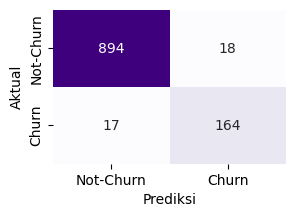

In [ ]:
# Classification Report pada Kondisi Threshold Normal (0.5)
from sklearn.metrics import classification_report, recall_score, fbeta_score

y_pred = pipe_model.predict(x_test)
print(classification_report(y_test, y_pred))
print('recall score :', round(recall_score(y_test, y_pred),3))
f2_score = fbeta_score(y_test, y_pred, beta=2)
print(f'f2 score : {f2_score:.3f}')

# Heatmap Confusion Matrix pada threshold 0.5
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(3,2))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True, fmt='.0f', cmap='Purples', cbar=False,
    xticklabels=['Not-Churn', 'Churn'],  # Ubah label sumbu X
    yticklabels=['Not-Churn', 'Churn']   # Ubah label sumbu Y
)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

Model prediksi *churn* ini menunjukkan performa yang sangat baik dengan **akurasi 97%** dan **F2-score sebesar 0.905**. Nilai **recall** untuk kelas *churn* mencapai 0.91, menunjukkan kemampuan model dalam mendeteksi pelanggan yang benar-benar churn sangat tinggi.

Berdasarkan *confusion matrix*:

* **True Positive (TP):** 164 (Churn terprediksi dengan benar)
* **True Negative (TN):** 894 (Bukan churn terprediksi dengan benar)
* **False Positive (FP):** 18 (Bukan churn yang salah diprediksi churn)
* **False Negative (FN):** 17 (Churn yang tidak terdeteksi model)

Kesalahan prediksi tergolong sangat rendah, dengan hanya 17 kasus churn yang tidak terdeteksi dan 18 pelanggan non-churn yang salah diprediksi churn.


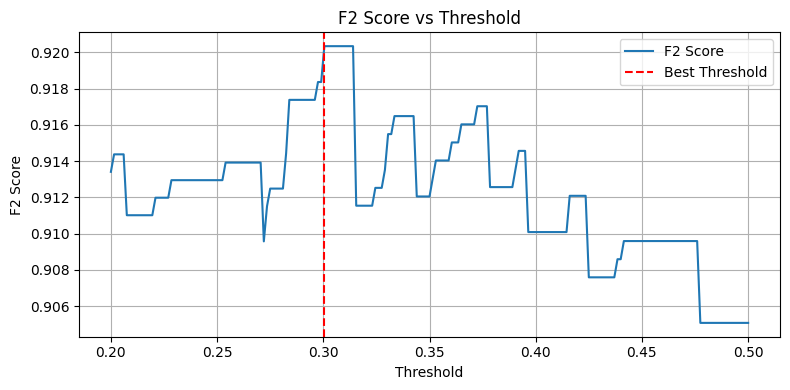

,threshold,f2
0,0.3005,0.920344


In [ ]:
# Menentukan threshold dan menghitung F2-score
list_threshold = np.linspace(0.2, 0.5, 201)
list_f2 = []

for threshold in list_threshold:
    y_probs = pipe_model.predict_proba(x_test)[:, 1]
    y_pred_new = (y_probs >= threshold).astype(int)
    f2 = fbeta_score(y_test, y_pred_new, beta=2)
    list_f2.append(f2)

# Buat DataFrame
df_threshold = pd.DataFrame({
    'threshold': list_threshold,
    'f2': list_f2,
})

# Plot sebelum disorting
plt.figure(figsize=(8, 4))
plt.plot(df_threshold['threshold'], df_threshold['f2'], label='F2 Score')
plt.axvline(x=df_threshold.loc[df_threshold['f2'].idxmax(), 'threshold'], color='red', linestyle='--', label='Best Threshold')
plt.title('F2 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F2 Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Ambil threshold terbaik
df_threshold = df_threshold.sort_values(by='f2', ascending=False).reset_index(drop=True)
threshold = df_threshold['threshold'][0]
df_threshold.head(1)


### **2.3.3 Penentuan Threshold Optimal Berdasarkan F2-score**

Grafik menunjukkan hubungan antara *threshold* klasifikasi dengan nilai F2-score. Nilai F2-score tertinggi tercapai pada threshold **0.30**, dengan skor **0.92**. Pengaturan threshold di angka ini mampu memaksimalkan deteksi churn dengan tetap menjaga keseimbangan antara *recall* dan *precision*.
Threshold optimum ini dapat digunakan untuk meningkatkan kinerja model dalam mengidentifikasi pelanggan yang berisiko *churn*, sehingga pengambilan keputusan menjadi lebih efektif.


              precision    recall  f1-score   support

           0       0.99      0.96      0.98       912
           1       0.83      0.94      0.89       181

    accuracy                           0.96      1093
   macro avg       0.91      0.95      0.93      1093
weighted avg       0.96      0.96      0.96      1093

recall score : 0.945
f2 score : 0.920


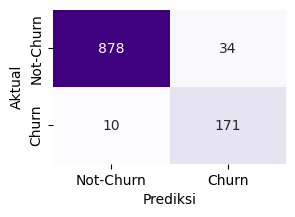

In [ ]:
# Mengubah Threshold untuk mendapat nilai F2 optimum
y_probs = pipe_model.predict_proba(x_test)[:,1]
y_pred_new = (y_probs >= threshold).astype(int)

# Classification Report Setelah Menurunkan Threshold Probability
print(classification_report(y_test, y_pred_new))
print(f'recall score : {recall_score(y_test, y_pred_new):.3f}')
f2_score = fbeta_score(y_test, y_pred_new, beta=2)
print(f'f2 score : {f2_score:.3f}')

# Heatmap Confusion Matrix
plt.figure(figsize=(3,2))
sns.heatmap(
    confusion_matrix(y_test, y_pred_new),
    annot=True, fmt='.0f', cmap='Purples', cbar=False,
    xticklabels=['Not-Churn', 'Churn'],  # Ubah label sumbu X
    yticklabels=['Not-Churn', 'Churn']   # Ubah label sumbu Y
)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

### **2.3.4 Evaluasi Model pada Threshold Optimal**

| **Metrik Evaluasi (Churn)** | **Threshold 0.5** | **Threshold Optimum** |
| --------------------------- | ----------------- | --------------------- |
| **Precision**               | 0.90              | 0.83                  |
| **Recall**                  | 0.91              | 0.94                  |
| **F1-Score**                | 0.90              | 0.88                  |
| **F2 Score**                | 0.905             | 0.920                 |
| **True Positive (TP)**      | 164               | 171                   |
| **False Negative (FN)**     | 17                | 10                    |
| **False Positive (FP)**     | 18                | 34                    |
| **Support (Actual Churn)**  | 181               | 181                   |




**Analisis Penerapan Threshold Optimum**

Model dengan **threshold optimum** berhasil menurunkan jumlah pelanggan churn yang gagal terdeteksi (FN turun dari 17 menjadi 10) dan meningkatkan **recall** dari 0.91 ke 0.94. Ini menghasilkan **peningkatan F2 score menjadi 0.920**, menandakan bahwa model menjadi **lebih efektif untuk mendeteksi churn**, meskipun terjadi *trade-off* berupa penurunan *precision* dan meningkatnya *false positive*.


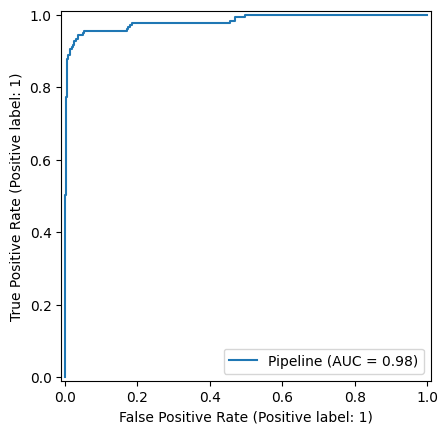

In [ ]:
from sklearn.metrics import RocCurveDisplay
roc_curve = RocCurveDisplay.from_estimator(pipe_model, x_test, y_test)

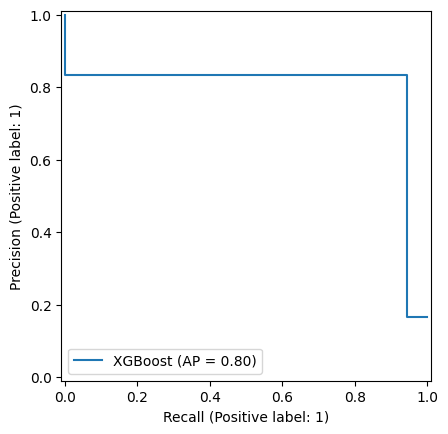

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
disp = PrecisionRecallDisplay.from_predictions(y_test, y_pred_new, name="XGBoost")

### **2.3.5 Evaluasi Kurva ROC dan Precision-Recall**

Model menunjukkan performa sangat baik dengan **AUC sebesar 0.98**, menandakan kemampuan tinggi dalam membedakan pelanggan churn dan *non*-*churn*. Kurva *precision*-*recall* juga menunjukkan hasil yang kuat dengan **average precision (AP) sebesar 0.80**, mencerminkan keseimbangan yang baik antara precision dan recall. Hasil ini mengonfirmasi bahwa model efektif dalam mendeteksi pelanggan churn dengan tingkat kesalahan rendah.


## **2.4 Kesimpulan Kinerja Model Skenario-1 (Sebelum Pembersihan Fitur Tidak Aman dan Fitur Berisiko)**

Model menunjukkan performa yang sangat tinggi dengan F2 score 0.920 dan AUC 0.98, menandakan kemampuan deteksi *churn* yang tampaknya sangat baik. **Namun, hasil ini diperoleh dari model yang masih mengandung fitur tidak aman (berisiko data leakage)**. Hal ini menyebabkan model belajar dari informasi yang seharusnya tidak tersedia saat prediksi, sehingga **hasil evaluasi tidak sepenuhnya mencerminkan kondisi prediksi saat deployment**. Oleh karena itu, **model perlu dievaluasi ulang setelah fitur leakage dihapus** untuk memastikan keandalan performanya dalam penggunaan nyata.

Dari confusion matrix, diperoleh:

* **True Positive (TP) = 171**: Pelanggan *churn* yang berhasil diprediksi dengan benar sebagai *churn*.
* **True Negative (TN) = 878**: Pelanggan tidak *churn* yang berhasil dikenali sebagai tidak churn.
* **False Positive (FP) = 34**: Pelanggan yang tidak churn tetapi salah diprediksi sebagai churn, yang berpotensi menyebabkan intervensi yang tidak perlu.
* **False Negative (FN) = 10**: Pelanggan churn yang gagal terdeteksi, berisiko kehilangan pelanggan tanpa upaya retensi.

Nilai FN yang rendah dan TP yang tinggi menunjukkan kemampuan deteksi churn yang sangat kuat, namun perlu divalidasi kembali tanpa adanya fitur yang berpotensi menyebabkan kebocoran data.


#**3 Machine Learning untuk Skenario 2: Drop Fitur Tidak Aman**

##**3.1 Preprocessing Skenario 2: Drop Fitur yang Tidak Aman**

In [ ]:
df['Complain']= df['Complain'].astype(int)
X = df.drop(['Churn', 'Tenure'], axis=1)
y = df['Churn']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020, stratify=y)

Pada skenario ini, dilakukan pendekatan yang lebih ketat dalam mengeliminasi potensi *data leakage* dengan **menghapus fitur yang tidak aman**. Fitur yang dihapus adalah:

* **Fitur Tidak Aman**:

  * `Tenure`
    Memiliki nilai IV sebesar 1.759 yang sangat tinggi, serta WoE ekstrem pada beberapa bin, menandakan potensi kuat terjadinya *target leakage*.

Setelah itu, data dibagi menjadi **data latih (80%)** dan **data uji (20%)** secara **stratified**, guna menjaga distribusi kelas tetap proporsional. Parameter acak ditetapkan agar proses dapat direproduksi dengan konsisten.


In [ ]:
impute_cols = [
    'OrderAmountHikeFromlastYear', 'CouponUsed',
    'OrderCount', 'DaySinceLastOrder'
]

binning_cols = [
    'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered',
    'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed',
    'OrderCount', 'DaySinceLastOrder', 'CashbackAmount'
]

categorical_cols = [
    'PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus'
]
ordinal_cols = ['CityTier', 'SatisfactionScore']

num_transformers = []

for col in binning_cols:
    steps = []
    # Jika butuh imputasi
    if col in impute_cols:
        imputer = IterativeImputer(
            estimator=XGBRegressor(n_estimators=100, max_depth=3, verbosity=0, random_state=42),
            max_iter=10, random_state=0
        )
        # Fit dulu untuk dapetin data imputasi training
        imputed_train_col = imputer.fit_transform(x_train[[col]])
        train_col_data = pd.Series(imputed_train_col.ravel())
    else:
        train_col_data = x_train[col]
        imputer = None

    # Fit OptBinning hanya di training
    binning = OptimalBinning(name=col, dtype="numerical")
    binning.fit(train_col_data.values, y_train)
    splits = binning.splits

    # Siapkan pipeline steps
    if imputer is not None:
        steps.append(('imputer', imputer))
    steps.append(('binning', OptBinningTransformer(splits)))
    col_pipe = Pipeline(steps)
    num_transformers.append((f'{col}_pipe', col_pipe, [col]))

cat_transformer = ('cat_ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols)
ord_transformer = ('ord_enc', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_cols)

transformer = ColumnTransformer(
    transformers=num_transformers + [cat_transformer, ord_transformer],
    remainder='passthrough'
)

transformer.fit(x_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('WarehouseToHome_pipe',
                                 Pipeline(steps=[('binning',
                                                  OptBinningTransformer(splits=array([ 6.5,  7.5,  8.5,  9.5, 13.5, 14.5, 15.5, 18.5, 27.5])))]),
                                 ['WarehouseToHome']),
                                ('HourSpendOnApp_pipe',
                                 Pipeline(steps=[('binning',
                                                  OptBinningTransformer(splits=array([2.5, 3.5])))]),
                                 ['HourSpendOnApp']),
                                ('NumberOfDeviceReg...
                                                  OptBinningTransformer(splits=array([124.39500046, 129.63000488, 149.73999786, 154.63000488,
       162.43499756, 229.89000702])))]),
                                 ['CashbackAmount']),
                                ('cat_ohe',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['PreferredLoginDevice',
                                  'PreferredPaymentMode', 'Gender',
                                  'PreferedOrderCat', 'MaritalStatus']),
                                ('ord_enc',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['CityTier', 'SatisfactionScore'])])

##**3.2 Modelling Skenario 2: Drop Fitur yang Tidak Aman**

Pada *modelling* skenario 2 ini masih digunakan algoritma yang sama yaitu **Decision Tree, Random Forest, XGBoost, AdaBoost, Gradient Boosting dan LightGBM**

###**3.2.1 Fitting Model Dengan Preprocessing Binning (Tanpa Resampling)**

In [ ]:
# Definisi model
model1 = DecisionTreeClassifier(random_state=500, class_weight='balanced')
model2 = RandomForestClassifier(random_state=500, class_weight='balanced')
model3 = XGBClassifier(random_state=500, scale_pos_weight=np.sum(y_train==0)/np.sum(y_train==1), use_label_encoder=False, eval_metric='logloss')
model4 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2, random_state=500, class_weight='balanced'), random_state=500)
model5 = GradientBoostingClassifier(random_state=500)
model6 = LGBMClassifier(random_state=500, class_weight='balanced', verbose=-1)

# Daftar model dan nama
list_model = [model1, model2, model3, model4, model5, model6]
nama_model = ['Decision Tree', 'Random Forest', 'XGBoost', 'AdaBoost', 'Gradient Boosting', 'LightGBM']

# Cross-validation
kfold = StratifiedKFold(n_splits=5)
f2 = make_scorer(fbeta_score, beta=2)
list_scoring = ['recall', f2, 'roc_auc', 'average_precision']

# Evaluasi model
for i in range(len(list_model)):
    pipe_model = Imbpipeline([
        ('transformer', transformer),
        ('model', list_model[i])
    ])
    print(f'{nama_model[i]}')
    start_time = time.time()  # Mulai timer

    for scoring in list_scoring:
        cv_score = cross_val_score(estimator=pipe_model,
                                   X=x_train,
                                   y=y_train,
                                   cv=kfold,
                                   scoring=scoring)
        print(f'{scoring} score avg = {np.mean(cv_score):.3f}, std = {np.std(cv_score):.3f}')

    duration = time.time() - start_time  # Durasi training dan evaluasi
    print(f'Duration: {duration:.2f} seconds\n')

Decision Tree
recall score avg = 0.735, std = 0.035
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.735, std = 0.033
roc_auc score avg = 0.842, std = 0.020
average_precision score avg = 0.588, std = 0.043
Duration: 1.67 seconds

Random Forest
recall score avg = 0.616, std = 0.039
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.664, std = 0.035
roc_auc score avg = 0.964, std = 0.007
average_precision score avg = 0.897, std = 0.026
Duration: 11.11 seconds

XGBoost
recall score avg = 0.818, std = 0.037
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.822, std = 0.034
roc_auc score avg = 0.956, std = 0.011
average_precision score avg = 0.886, std = 0.038
Duration: 5.39 seconds

AdaBoost
recall score avg = 0.597, std = 0.069
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.517, std = 0.039
roc_auc score avg = 0.734, std = 0.041
average_precision score avg = 0.358, std = 0.067
Duration: 1.97

| Model            | F2 Score (avg) | Duration (s) |
|------------------|----------------|--------------|
| XGBoost          | 0.822          | 5.39         |
| LightGBM         | 0.806          | 3.43         |
| Decision Tree    | 0.735          | 1.67         |
| Random Forest    | 0.664          | 11.11        |
| AdaBoost         | 0.517          | 1.97         |
| Gradient Boosting| 0.435          | 13.78        |


XGBoost memberikan F2 Score tertinggi (0.822) dengan durasi pemrosesan yang masih efisien. LightGBM juga efektif dan lebih cepat. Model lain memiliki F2 Score lebih rendah atau durasi lebih lama. XGBoost adalah pilihan terbaik untuk prediksi *churn* pada data ini.


### **3.2.2 Eksperimen Fitting Model Jika Tidak Dilakukan Binning Terlebih Dahulu**

In [ ]:
# Skenario 2 Jika Tidak Diterapkan Binning

df['Complain']=df['Complain'].astype('int')
X = df.drop(['Churn','Tenure'], axis=1)
y = df['Churn']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020, stratify=y)

# Kolom yang akan di-imputasi (sebelum binning)
impute_cols = [
    'OrderAmountHikeFromlastYear',
    'CouponUsed',
    'OrderCount',
    'DaySinceLastOrder',
    'WarehouseToHome',
    'HourSpendOnApp'
]

# Fitur kategorikal
categorical_cols = [
    'PreferredLoginDevice', 'PreferredPaymentMode',
    'Gender', 'PreferedOrderCat', 'MaritalStatus'
]

# Regressor untuk imputasi
xgboostreg = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, verbosity=0, n_jobs=-1, random_state=42)
imputer = IterativeImputer(estimator=xgboostreg, max_iter=10, random_state=0)


numerical_transformer0 = ('imputer', imputer, impute_cols)

# Buat transformer kategorikal (OneHotEncoder)
categorical_transformer0 = ('cat_ohe',
    OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
    categorical_cols
)

# Tambahkan fitur ordinal
ordinal_cols = ['CityTier', 'SatisfactionScore']
ordinal_transformer0 = ('ordinal_enc',
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    ordinal_cols
)

# Gabungkan semua ke ColumnTransformer
transformer0 = ColumnTransformer(
    transformers=[numerical_transformer0,categorical_transformer0,ordinal_transformer0],
    remainder='passthrough'
)

# Fit transformer ke data
transformer0.fit(x_train, y_train)

# Definisi model
model1 = DecisionTreeClassifier(random_state=500, class_weight='balanced')
model2 = RandomForestClassifier(random_state=500, class_weight='balanced')
model3 = XGBClassifier(random_state=500, scale_pos_weight=np.sum(y_train==0)/np.sum(y_train==1), use_label_encoder=False, eval_metric='logloss')
model4 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2, random_state=500, class_weight='balanced'), random_state=500)
model5 = GradientBoostingClassifier(random_state=500)
model6 = LGBMClassifier(random_state=500, class_weight='balanced', verbose=-1)

# Daftar model dan nama
list_model = [model1, model2, model3, model4, model5, model6]
nama_model = ['Decision Tree', 'Random Forest', 'XGBoost', 'AdaBoost', 'Gradient Boosting', 'LightGBM']

# Cross-validation
kfold = StratifiedKFold(n_splits=5)
f2 = make_scorer(fbeta_score, beta=2)
list_scoring = ['recall', f2, 'roc_auc', 'average_precision']

# Evaluasi model
for i in range(len(list_model)):
    pipe_model = Imbpipeline([
        ('transformer', transformer0),
        ('model', list_model[i])
    ])
    print(f'{nama_model[i]}')
    start_time = time.time()  # Mulai timer

    for scoring in list_scoring:
        cv_score = cross_val_score(estimator=pipe_model,
                                   X=x_train,
                                   y=y_train,
                                   cv=kfold,
                                   scoring=scoring)
        print(f'{scoring} score avg = {np.mean(cv_score):.3f}, std = {np.std(cv_score):.3f}')

    duration = time.time() - start_time  # Durasi training dan evaluasi
    print(f'Duration: {duration:.2f} seconds\n')

Decision Tree
recall score avg = 0.746, std = 0.042
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.746, std = 0.035
roc_auc score avg = 0.848, std = 0.020
average_precision score avg = 0.601, std = 0.036
Duration: 72.13 seconds

Random Forest
recall score avg = 0.617, std = 0.057
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.664, std = 0.051
roc_auc score avg = 0.968, std = 0.005
average_precision score avg = 0.903, std = 0.022
Duration: 84.58 seconds

XGBoost
recall score avg = 0.814, std = 0.041
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.822, std = 0.035
roc_auc score avg = 0.957, std = 0.008
average_precision score avg = 0.893, std = 0.029
Duration: 76.00 seconds

AdaBoost
recall score avg = 0.547, std = 0.107
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.477, std = 0.074
roc_auc score avg = 0.729, std = 0.029
average_precision score avg = 0.334, std = 0.037
Duration: 72

| Model            | F2 Score (No Binning) | F2 Score (Binning) | ΔF2 (Binning-NoBin) | Durasi No Binning (s) | Durasi Binning (s) | Binning Lebih Cepat (kali) |
|------------------|-----------------------|--------------------|---------------------|-----------------------|--------------------|-----------------------------|
| XGBoost          | 0.822                 | 0.822              | 0.000               | 76.00                 | 5.39               | 14.1                        |
| LightGBM         | 0.816                 | 0.806              | -0.010              | 72.52                 | 3.43               | 21.2                        |
| Decision Tree    | 0.746                 | 0.735              | -0.011              | 72.13                 | 1.67               | 43.2                        |
| Random Forest    | 0.664                 | 0.664              | 0.000               | 84.58                 | 11.11              | 7.6                         |
| AdaBoost         | 0.477                 | 0.517              | +0.040              | 72.31                 | 1.97               | 36.7                        |
| Gradient Boosting| 0.430                 | 0.435              | +0.005              | 90.17                 | 13.78              | 6.5                         |


Setelah diterapkan *binning*, performa model terbaik seperti **XGBoost** dan **LightGBM** tetap sangat tinggi, dengan *F2 score* masing-masing 0.822 dan 0.806. Selain itu, proses *training* seluruh model menjadi jauh lebih cepat, bahkan hingga puluhan kali lipat dibandingkan tanpa binning. Efisiensi waktu ini dicapai tanpa penurunan berarti pada performa deteksi *churn*, bahkan beberapa model justru mengalami peningkatan *F2 score* setelah binning. Dengan demikian, penggunaan binning terbukti **lebih baik** karena mampu menjaga akurasi model sekaligus secara signifikan mempercepat proses *training*.


### **3.2.3 Eksperimen Fitting Model dengan Preprocessing Binning yang disertai Resampling (SMOTE)**

In [ ]:
# Definisi model
model1 = DecisionTreeClassifier(random_state=500, class_weight='balanced')
model2 = RandomForestClassifier(random_state=500, class_weight='balanced')
model3 = XGBClassifier(random_state=500, scale_pos_weight=np.sum(y_train==0)/np.sum(y_train==1), use_label_encoder=False, eval_metric='logloss')
model4 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2, random_state=500, class_weight='balanced'), random_state=500)
model5 = GradientBoostingClassifier(random_state=500)
model6 = LGBMClassifier(random_state=500, class_weight='balanced', verbose=-1)

# Daftar model dan nama
list_model = [model1, model2, model3, model4, model5, model6]
nama_model = ['Decision Tree', 'Random Forest', 'XGBoost', 'AdaBoost', 'Gradient Boosting', 'LightGBM']
smote = SMOTE(random_state=500)

# Cross-validation
kfold = StratifiedKFold(n_splits=5)
f2 = make_scorer(fbeta_score, beta=2)
list_scoring = ['recall', f2, 'roc_auc', 'average_precision']

# Evaluasi model
for i in range(len(list_model)):
    pipe_model = Imbpipeline([
        ('transformer', transformer),
        ('smote', smote),
        ('model', list_model[i])
    ])
    print(f'{nama_model[i]}')
    start_time = time.time()  # Mulai timer

    for scoring in list_scoring:
        cv_score = cross_val_score(estimator=pipe_model,
                                   X=x_train,
                                   y=y_train,
                                   cv=kfold,
                                   scoring=scoring)
        print(f'{scoring} score avg = {np.mean(cv_score):.3f}, std = {np.std(cv_score):.3f}')

    duration = time.time() - start_time  # Durasi training dan evaluasi
    print(f'Duration: {duration:.2f} seconds\n')

Decision Tree
recall score avg = 0.721, std = 0.040
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.711, std = 0.035
roc_auc score avg = 0.826, std = 0.021
average_precision score avg = 0.535, std = 0.039
Duration: 3.15 seconds

Random Forest
recall score avg = 0.630, std = 0.033
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.671, std = 0.031
roc_auc score avg = 0.954, std = 0.009
average_precision score avg = 0.865, std = 0.033
Duration: 18.72 seconds

XGBoost
recall score avg = 0.802, std = 0.038
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.807, std = 0.031
roc_auc score avg = 0.951, std = 0.008
average_precision score avg = 0.873, std = 0.036
Duration: 18.07 seconds

AdaBoost
recall score avg = 0.526, std = 0.019
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.524, std = 0.026
roc_auc score avg = 0.831, std = 0.018
average_precision score avg = 0.550, std = 0.038
Duration: 17.

| Model            | F2 Score (Binning) | F2 Score (Binning+SMOTE) | ΔF2 (SMOTE - Binning) | Durasi Binning (s) | Durasi SMOTE (s) | Binning Lebih Cepat (kali) |
|------------------|--------------------|--------------------------|-----------------------|--------------------|------------------|----------------------------|
| XGBoost          | 0.822              | 0.807                    | -0.015                | 5.39               | 18.07            | 3.4                        |
| LightGBM         | 0.806              | 0.662                    | -0.144                | 3.43               | 9.87             | 2.9                        |
| Decision Tree    | 0.735              | 0.711                    | -0.024                | 1.67               | 3.15             | 1.9                        |
| Random Forest    | 0.664              | 0.671                    | +0.007                | 11.11              | 18.72            | 1.7                        |
| AdaBoost         | 0.517              | 0.524                    | +0.007                | 1.97               | 17.95            | 9.1                        |
| Gradient Boosting| 0.435              | 0.517                    | +0.082                | 13.78              | 13.63            | 1.0                        |


Berdasarkan hasil komparasi, model dengan **binning saja** secara konsisten memberikan waktu *training* yang jauh lebih singkat dibandingkan kombinasi binning + SMOTE, dengan kecepatan hingga lebih dari 3 kali lipat pada model seperti XGBoost dan LightGBM. Selain itu, *F2 score* pada sebagian besar model justru **lebih tinggi pada skenario binning saja**. Hal ini menunjukkan bahwa penambahan SMOTE tidak memberikan peningkatan performa deteksi churn yang signifikan, bahkan pada beberapa model justru menurunkan *F2 score*. Dengan demikian, **binning saja terbukti lebih efektif dan efisien** baik dari sisi performa maupun waktu proses.


### **3.2.4 Eksperimen Fitting Model dengan Preprocessing Binning yang disertai Resampling (ENN)**

In [ ]:
from imblearn.under_sampling import EditedNearestNeighbours

# Inisialisasi ENN
enn = EditedNearestNeighbours()

# Daftar model dan nama tetap sama
list_model = [model1, model2, model3, model4, model5, model6]
nama_model = ['Decision Tree', 'Random Forest', 'XGBoost', 'AdaBoost', 'Gradient Boosting', 'LightGBM']

# Cross-validation
kfold = StratifiedKFold(n_splits=5)
f2 = make_scorer(fbeta_score, beta=2)
list_scoring = ['recall', f2, 'roc_auc', 'average_precision']

# Evaluasi model dengan ENN
for i in range(len(list_model)):
    pipe_model = Imbpipeline([
        ('transformer', transformer),
        ('resampling', enn),  # Ganti SMOTE dengan ENN
        ('model', list_model[i])
    ])
    print(f'{nama_model[i]}')
    start_time = time.time()  # Mulai timer

    for scoring in list_scoring:
        cv_score = cross_val_score(estimator=pipe_model,
                                   X=x_train,
                                   y=y_train,
                                   cv=kfold,
                                   scoring=scoring)
        print(f'{scoring} score avg = {np.mean(cv_score):.3f}, std = {np.std(cv_score):.3f}')

    duration = time.time() - start_time  # Durasi training dan evaluasi
    print(f'Duration: {duration:.2f} seconds\n')


Decision Tree
recall score avg = 0.762, std = 0.020
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.719, std = 0.017
roc_auc score avg = 0.827, std = 0.011
average_precision score avg = 0.485, std = 0.016
Duration: 2.98 seconds

Random Forest
recall score avg = 0.693, std = 0.026
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.711, std = 0.024
roc_auc score avg = 0.949, std = 0.010
average_precision score avg = 0.828, std = 0.029
Duration: 11.54 seconds

XGBoost
recall score avg = 0.848, std = 0.031
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.798, std = 0.025
roc_auc score avg = 0.942, std = 0.007
average_precision score avg = 0.779, std = 0.027
Duration: 4.60 seconds

AdaBoost
recall score avg = 0.591, std = 0.035
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.516, std = 0.022
roc_auc score avg = 0.698, std = 0.037
average_precision score avg = 0.295, std = 0.053
Duration: 4.03

| Model            | F2 Score (Binning) | F2 Score (Binning+ENN) | ΔF2 (ENN - Binning) | Durasi Binning (s) | Durasi ENN (s) | Binning Lebih Cepat (kali) |
|------------------|--------------------|------------------------|---------------------|--------------------|----------------|----------------------------|
| XGBoost          | 0.822              | 0.798                  | -0.024              | 5.39               | 4.60           | 0.9                        |
| LightGBM         | 0.806              | 0.795                  | -0.011              | 3.43               | 4.64           | 1.4                        |
| Decision Tree    | 0.735              | 0.719                  | -0.016              | 1.67               | 2.98           | 1.8                        |
| Random Forest    | 0.664              | 0.711                  | +0.047              | 11.11              | 11.54          | 1.0                        |
| AdaBoost         | 0.517              | 0.516                  | -0.001              | 1.97               | 4.03           | 2.0                        |
| Gradient Boosting| 0.435              | 0.546                  | +0.111              | 13.78              | 13.42          | 1.0                        |


Berdasarkan hasil komparasi, penerapan **binning saja** umumnya tetap memberikan hasil yang lebih baik secara keseluruhan dibandingkan kombinasi binning + ENN. Hampir seluruh model menunjukkan F2 score yang lebih tinggi pada skenario binning saja, sementara penambahan ENN justru menyebabkan penurunan performa pada sebagian besar model. Selain itu, durasi proses pada binning saja umumnya juga lebih singkat atau tidak jauh berbeda dengan kombinasi ENN. Dengan demikian, **binning saja lebih direkomendasikan** karena lebih efisien dan mampu menjaga performa deteksi churn secara optimal.
Sebagai tambahan, **XGBoost dengan binning saja menjadi model dengan performa terbaik**, sehingga sangat layak dijadikan pilihan utama dalam kasus ini.


##**3.3 Hyperparameter Tuning Skenario 2: Drop Fitur yang Tidak Aman**

###**3.3.1 Optimasi Model XGBoost Menggunakan Randomized Search**

Proses optimasi model XGBoost dilakukan menggunakan pendekatan **Randomized Search Cross-Validation** sebanyak 500 iterasi, dengan tujuan memperoleh kombinasi parameter terbaik berdasarkan metrik **F2-score**. Teknik ini sama seperti yang diterapkan pada **Skenario 1**, yaitu dengan menggabungkan *pipeline* transformasi dan model ke dalam satu kesatuan yang dievaluasi secara menyeluruh.

Parameter yang *dituning* mencakup jumlah pohon (`n_estimators`), laju pembelajaran (`learning_rate`), kedalaman pohon, serta parameter regulasi seperti `gamma`, `subsample`, dan `colsample_bytree`. Evaluasi dilakukan dengan **Stratified K-Fold** (5 lipatan), untuk memastikan distribusi kelas tetap seimbang.

Hasil akhir dari proses *tuning* meliputi:

* Kombinasi parameter terbaik (ditentukan secara otomatis oleh `RandomizedSearchCV`)
* Nilai F2-score tertinggi pada data validasi
* Durasi waktu pelatihan

Dengan pendekatan ini, model XGBoost disiapkan secara optimal untuk mendeteksi pelanggan churn dengan sensitivitas yang tinggi dan performa yang stabil.



In [ ]:
# Model XGBoost
xgb_model = XGBClassifier(random_state=500, scale_pos_weight=np.sum(y_train==0)/np.sum(y_train==1), use_label_encoder=False, eval_metric='logloss')

# Cross-validation
cv = StratifiedKFold(n_splits=5)

# Pipeline
pipe_model = Imbpipeline([
    ('transformer', transformer),   # sudah didefinisikan sebelumnya
    ('model', xgb_model)
])

# Parameter grid
param_dist = {
    'model__n_estimators': randint(100, 500),
    'model__learning_rate': uniform(0.01, 0.1),
    'model__max_depth': randint(3, 10),
    'model__subsample': uniform(0.6, 0.4),
    'model__colsample_bytree': uniform(0.6, 0.4),
    'model__min_child_weight': randint(1, 10),
    'model__gamma': uniform(0, 5)
}

# F2 scorer
scorer = make_scorer(fbeta_score, beta=2)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=pipe_model,
    param_distributions=param_dist,
    n_iter=500,
    scoring=scorer,
    cv=cv,
    verbose=3,
    n_jobs=-1,
    random_state=42
)

# Hitung waktu training
start_time = time.time()

# Training
random_search.fit(x_train, y_train)

end_time = time.time()
duration = end_time - start_time

# Output hasil terbaik
print("Best parameters found: ", random_search.best_params_)
print("Best F2 score: ", random_search.best_score_)
print(f"Training duration: {duration:.2f} seconds ({duration/60:.2f} minutes)")


Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best parameters found:  {'model__colsample_bytree': np.float64(0.9178313114800761), 'model__gamma': np.float64(0.17335133363241662), 'model__learning_rate': np.float64(0.06828068350834897), 'model__max_depth': 8, 'model__min_child_weight': 2, 'model__n_estimators': 354, 'model__subsample': np.float64(0.8635300280560282)}
Best F2 score:  0.8273990936435043
Training duration: 607.94 seconds (10.13 minutes)


###**3.3.2 Fitting Model XGBoost dengan Parameter Terbaik**

In [ ]:
model = XGBClassifier(random_state=500, scale_pos_weight=np.sum(y_train==0)/np.sum(y_train==1), use_label_encoder=False, eval_metric='logloss')
pipe_model = Imbpipeline([
    ('transformer', transformer),
    ('model', model)
])

best_params = {'model__colsample_bytree': np.float64(0.9178313114800761), 'model__gamma': np.float64(0.17335133363241662), 'model__learning_rate': np.float64(0.06828068350834897), 'model__max_depth': 8, 'model__min_child_weight': 2, 'model__n_estimators': 354, 'model__subsample': np.float64(0.8635300280560282)}

pipe_model = pipe_model.set_params(**best_params)
pipe_model.fit(x_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('WarehouseToHome_pipe',
                                                  Pipeline(steps=[('binning',
                                                                   OptBinningTransformer(splits=array([ 6.5,  7.5,  8.5,  9.5, 13.5, 14.5, 15.5, 18.5, 27.5])))]),
                                                  ['WarehouseToHome']),
                                                 ('HourSpendOnApp_pipe',
                                                  Pipeline(steps=[('binning',
                                                                   OptBinningTransformer(splits=array([2.5, 3.5])))]),
                                                  ['HourSp...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=np.float64(0.06828068350834897),
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None, min_child_weight=2,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=354,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=500, ...))])

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       912
           1       0.91      0.91      0.91       181

    accuracy                           0.97      1093
   macro avg       0.95      0.94      0.95      1093
weighted avg       0.97      0.97      0.97      1093

recall score : 0.906
f2 score : 0.907


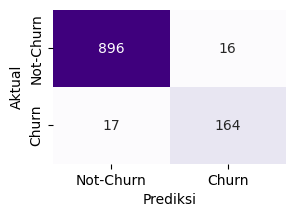

In [ ]:
# Classification Report pada Kondisi Threshold Normal (0.5)
from sklearn.metrics import classification_report, recall_score, fbeta_score

y_pred = pipe_model.predict(x_test)
print(classification_report(y_test, y_pred))
print('recall score :', round(recall_score(y_test, y_pred),3))
f2_score = fbeta_score(y_test, y_pred, beta=2)
print(f'f2 score : {f2_score:.3f}')

plt.figure(figsize=(3,2))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True, fmt='.0f', cmap='Purples', cbar=False,
    xticklabels=['Not-Churn', 'Churn'],  # Ubah label sumbu X
    yticklabels=['Not-Churn', 'Churn']   # Ubah label sumbu Y
)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

Model menunjukkan kinerja yang sangat baik dalam mendeteksi *churn* dengan **F2 score sebesar 0.907** dan **akurasi 0.97**. Nilai precision dan recall yang seimbang pada kelas *churn* (masing-masing 0.91) menandakan model mampu menangkap sebagian besar pelanggan yang benar-benar *churn*, tanpa mengorbankan banyak prediksi yang salah.

Berdasarkan confusion matrix:

* **True Positive (TP) = 164**: Pelanggan *churn* yang berhasil diprediksi dengan benar sebagai *churn*.
* **True Negative (TN) = 896**: Pelanggan tidak *churn* yang diprediksi dengan benar sebagai tidak *churn*.
* **False Positive (FP) = 16**: Pelanggan tidak *churn* yang salah diprediksi sebagai *churn*, berpotensi menyebabkan intervensi yang tidak perlu.
* **False Negative (FN) = 17**: Pelanggan *churn* yang gagal terdeteksi, sehingga berisiko kehilangan pelanggan tanpa upaya retensi.

Secara keseluruhan, model ini sudah sangat optimal untuk tujuan deteksi *churn* karena mampu menjaga keseimbangan antara *false positive* dan *false negative* dengan baik.


### **3.3.3 Penentuan Threshold Optimal Berdasarkan F2-score**


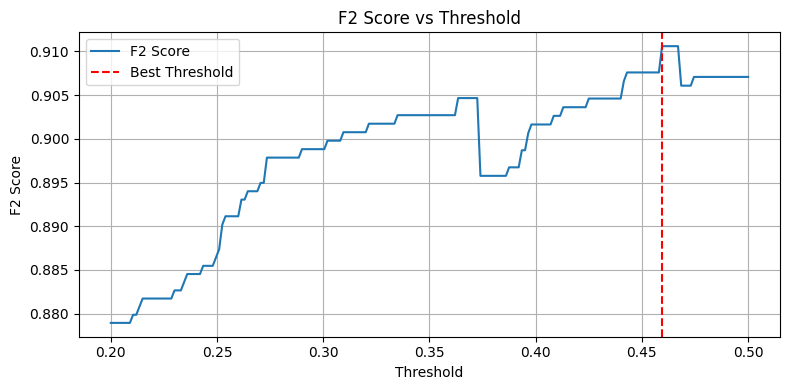

,threshold,f2
0,0.467,0.910596


In [ ]:
# Menentukan threshold dan menghitung F2-score
list_threshold = np.linspace(0.2, 0.5, 201)
list_f2 = []

for threshold in list_threshold:
    y_probs = pipe_model.predict_proba(x_test)[:, 1]
    y_pred_new = (y_probs >= threshold).astype(int)
    f2 = fbeta_score(y_test, y_pred_new, beta=2)
    list_f2.append(f2)

# Buat DataFrame
df_threshold = pd.DataFrame({
    'threshold': list_threshold,
    'f2': list_f2,
})

# Plot sebelum disorting
plt.figure(figsize=(8, 4))
plt.plot(df_threshold['threshold'], df_threshold['f2'], label='F2 Score')
plt.axvline(x=df_threshold.loc[df_threshold['f2'].idxmax(), 'threshold'], color='red', linestyle='--', label='Best Threshold')
plt.title('F2 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F2 Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Ambil threshold terbaik
df_threshold = df_threshold.sort_values(by='f2', ascending=False).reset_index(drop=True)
threshold = df_threshold['threshold'][0]
df_threshold.head(1)


### **3.3.4 Evaluasi Model pada Threshold Optimal**

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       912
           1       0.91      0.91      0.91       181

    accuracy                           0.97      1093
   macro avg       0.94      0.95      0.95      1093
weighted avg       0.97      0.97      0.97      1093

recall score : 0.912
f2 score : 0.911


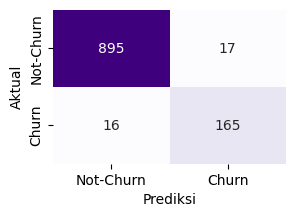

In [ ]:
# Mengubah Threshold untuk mendapat nilai F2 optimum
y_probs = pipe_model.predict_proba(x_test)[:,1]
y_pred_new = (y_probs >= threshold).astype(int)

# Classification Report Setelah Menurunkan Threshold Probability
print(classification_report(y_test, y_pred_new))
print(f'recall score : {recall_score(y_test, y_pred_new):.3f}')
f2_score = fbeta_score(y_test, y_pred_new, beta=2)
print(f'f2 score : {f2_score:.3f}')

# Heatmap Confusion Matrix
plt.figure(figsize=(3,2))
sns.heatmap(
    confusion_matrix(y_test, y_pred_new),
    annot=True, fmt='.0f', cmap='Purples', cbar=False,
    xticklabels=['Not-Churn', 'Churn'],  # Ubah label sumbu X
    yticklabels=['Not-Churn', 'Churn']   # Ubah label sumbu Y
)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

| Parameter         | Threshold 0.5 | Threshold Optimum |
|-------------------|---------------|-------------------|
| F2 Score          | 0.907         | 0.911             |
| Precision (Churn) | 0.91          | 0.91              |
| Recall (Churn)    | 0.91          | 0.91              |
| Accuracy          | 0.97          | 0.97              |
| TP (Churn)        | 164           | 165               |
| TN (Not Churn)    | 896           | 895               |
| FP                | 16            | 17                |
| FN                | 17            | 16                |


Perbandingan antara *threshold* 0.5 dan *threshold* optimum menunjukkan hasil yang sangat mirip pada seluruh metrik utama. Namun, *threshold* optimum memberikan keunggulan penting berupa **penurunan jumlah false negative** (dari 17 menjadi 16), sehingga lebih banyak pelanggan *churn* yang berhasil terdeteksi. Penurunan *false negative* ini sangat krusial dalam upaya retensi pelanggan, karena semakin sedikit pelanggan *churn* yang terlewat. Dengan demikian, *threshold* optimum lebih direkomendasikan karena mampu memaksimalkan deteksi *churn* tanpa mengorbankan presisi maupun akurasi model.


### **3.3.5 Evaluasi Kurva ROC dan Precision-Recall**

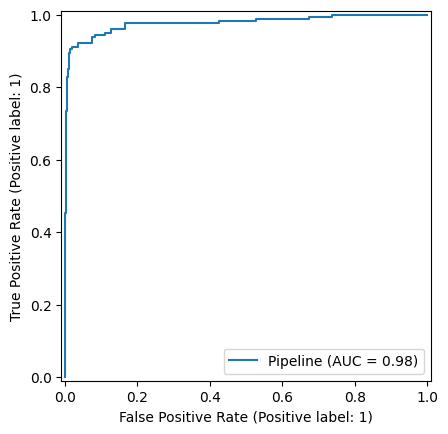

In [ ]:
from sklearn.metrics import RocCurveDisplay
roc_curve = RocCurveDisplay.from_estimator(pipe_model, x_test, y_test)

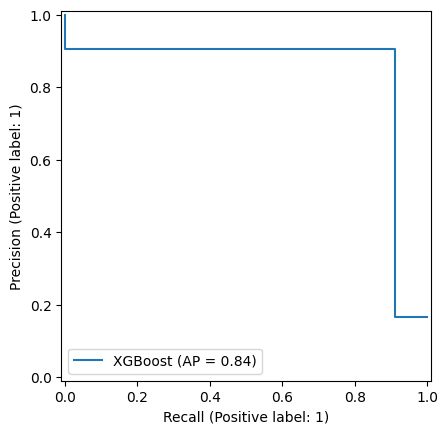

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
disp = PrecisionRecallDisplay.from_predictions(y_test, y_pred_new, name="XGBoost")

Berdasarkan kurva ROC, model memiliki **AUC sebesar 0.98**, yang menandakan kemampuan klasifikasi sangat baik dalam membedakan pelanggan *churn* dan tidak *churn*. Pada kurva *Precision-Recall*, nilai **Average Precision (AP) sebesar 0.84** juga menunjukkan bahwa model sangat konsisten dalam menjaga presisi meskipun recall meningkat. Kombinasi kedua metrik ini memperkuat bahwa model tidak hanya akurat, tetapi juga andal dalam mendeteksi pelanggan yang benar-benar berisiko *churn*, sehingga sangat layak digunakan untuk kebutuhan deteksi *churn* di e-commerce.


## **3.4 Kesimpulan Kinerja Model Skenario-2 (Sebelum Pembersihan Fitur Berisiko)**

Model menunjukkan performa yang sangat tinggi dengan F2 score 0.911 dan AUC 0.98, menandakan kemampuan deteksi churn yang tampaknya sangat baik. Namun, **hasil ini diperoleh dari model yang masih mengandung fitur yang masih berisiko leakage**. Hal ini menyebabkan model belajar dari informasi yang seharusnya tidak tersedia saat prediksi, sehingga hasil evaluasi tidak sepenuhnya mencerminkan kondisi prediksi saat *deployment*. Oleh karena itu, model perlu dievaluasi ulang setelah fitur *leakage* dihapus untuk memastikan keandalan performanya dalam penggunaan nyata.

Dari confusion matrix, diperoleh:

* **True Positive (TP) = 165**: Pelanggan churn yang berhasil diprediksi dengan benar sebagai churn.
* **True Negative (TN) = 895**: Pelanggan tidak churn yang berhasil dikenali sebagai tidak churn.
* **False Positive (FP) = 17**: Pelanggan yang tidak churn tetapi salah diprediksi sebagai churn, yang berpotensi menyebabkan intervensi yang tidak perlu.
* **False Negative (FN) = 16**: Pelanggan churn yang gagal terdeteksi, berisiko kehilangan pelanggan tanpa upaya retensi.

Nilai FN yang rendah dan TP yang tinggi menunjukkan kemampuan deteksi churn yang sangat kuat, namun perlu divalidasi kembali tanpa adanya fitur yang berpotensi menyebabkan kebocoran data.


#**4. Machine Learning untuk Skenario 3: Drop Fitur Tidak Aman dan Fitur yang Beresiko**

##**4.1 Preprocessing Skenario 3: Drop Fitur yang Tidak Aman dan Fitur yang Beresiko**

Pada skenario ini, dilakukan pendekatan yang lebih ketat dalam mengeliminasi potensi data leakage dengan **menghapus tidak hanya fitur yang tidak aman**, tetapi juga **fitur yang dinilai berisiko tinggi secara kausal**. Fitur yang dihapus meliputi:

* **Fitur Tidak Aman**:

  * `Tenure`
    Memiliki nilai IV sebesar 1.759 yang sangat tinggi, serta WoE ekstrem pada beberapa bin, menandakan potensi kuat terjadinya *target leakage*.

* **Fitur Berisiko**:

  * `CashbackAmount`
    Memiliki bin dengan WoE sebesar +1.99, yang menunjukkan distribusi target sangat timpang.
  * `CouponUsed`
    Memiliki WoE sebesar +2.09 pada bin "Missing", yang mengindikasikan ketidakseimbangan informasi dan perlu penanganan khusus terhadap nilai hilang..

Dengan penghapusan tiga fitur tersebut, model hanya dilatih menggunakan variabel-variabel yang dipastikan aman untuk digunakan dalam prediksi prospektif. Langkah ini bertujuan untuk **menghasilkan model yang benar-benar bebas dari kebocoran informasi** serta lebih andal digunakan dalam sistem yang memprediksi churn secara real-time.

Setelah fitur-fitur tersebut di-drop, data dibagi menjadi data latih dan data uji dengan komposisi 80:20 menggunakan teknik* stratified split *untuk menjaga proporsi kelas yang seimbang.

In [ ]:
df['Churn'] = df['Churn'].astype(int)
X = df.drop(['Churn', 'Tenure', 'CashbackAmount', 'CouponUsed'], axis=1)
y = df['Churn']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020, stratify=y)

In [ ]:
impute_cols = [
    'OrderAmountHikeFromlastYear',
    'OrderCount', 'DaySinceLastOrder'
]

binning_cols = [
    'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered',
    'NumberOfAddress', 'OrderAmountHikeFromlastYear',
    'OrderCount', 'DaySinceLastOrder'
]

categorical_cols = [
    'PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus'
]
ordinal_cols = ['CityTier', 'SatisfactionScore']

num_transformers = []

for col in binning_cols:
    steps = []
    # Jika butuh imputasi
    if col in impute_cols:
        imputer = IterativeImputer(
            estimator=XGBRegressor(n_estimators=100, max_depth=3, verbosity=0, random_state=42),
            max_iter=10, random_state=0
        )
        # Fit dulu untuk dapetin data imputasi training
        imputed_train_col = imputer.fit_transform(x_train[[col]])
        train_col_data = pd.Series(imputed_train_col.ravel())
    else:
        train_col_data = x_train[col]
        imputer = None

    # Fit OptBinning hanya di training
    binning = OptimalBinning(name=col, dtype="numerical")
    binning.fit(train_col_data.values, y_train)
    splits = binning.splits

    # Siapkan pipeline steps
    if imputer is not None:
        steps.append(('imputer', imputer))
    steps.append(('binning', OptBinningTransformer(splits)))
    col_pipe = Pipeline(steps)
    num_transformers.append((f'{col}_pipe', col_pipe, [col]))

cat_transformer = ('cat_ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols)
ord_transformer = ('ord_enc', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_cols)

transformer = ColumnTransformer(
    transformers=num_transformers + [cat_transformer, ord_transformer],
    remainder='passthrough'
)

transformer.fit(x_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('WarehouseToHome_pipe',
                                 Pipeline(steps=[('binning',
                                                  OptBinningTransformer(splits=array([ 6.5,  7.5,  8.5,  9.5, 13.5, 14.5, 15.5, 18.5, 27.5])))]),
                                 ['WarehouseToHome']),
                                ('HourSpendOnApp_pipe',
                                 Pipeline(steps=[('binning',
                                                  OptBinningTransformer(splits=array([2.5, 3.5])))]),
                                 ['HourSpendOnApp']),
                                ('NumberOfDeviceReg...
                                                  OptBinningTransformer(splits=array([ 0.5       ,  1.5       ,  2.5       ,  3.5       ,  4.75826693,
        7.5       ,  8.5       , 10.5       ])))]),
                                 ['DaySinceLastOrder']),
                                ('cat_ohe',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['PreferredLoginDevice',
                                  'PreferredPaymentMode', 'Gender',
                                  'PreferedOrderCat', 'MaritalStatus']),
                                ('ord_enc',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['CityTier', 'SatisfactionScore'])])

##**4.2 Modelling Skenario 3: Drop Fitur Tidak Aman dan Fitur Berisiko**

Pada modelling skenario 3 ini masih digunakan algoritma yang sama yaitu **Decision Tree, Random Forest, XGBoost, AdaBoost, Gradient Boosting dan LightGBM**

###**4.2.1 Fitting Model Dengan Preprocessing Binning (Tanpa Resampling)**

In [ ]:
# Definisi model
model1 = DecisionTreeClassifier(random_state=500, class_weight='balanced')
model2 = RandomForestClassifier(random_state=500, class_weight='balanced')
model3 = XGBClassifier(random_state=500, scale_pos_weight=np.sum(y_train==0)/np.sum(y_train==1), use_label_encoder=False, eval_metric='logloss')
model4 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2, random_state=500, class_weight='balanced'), random_state=500)
model5 = GradientBoostingClassifier(random_state=500)
model6 = LGBMClassifier(random_state=500, class_weight='balanced', verbose=-1)

# Daftar model dan nama
list_model = [model1, model2, model3, model4, model5, model6]
nama_model = ['Decision Tree', 'Random Forest', 'XGBoost', 'AdaBoost', 'Gradient Boosting', 'LightGBM']

# Cross-validation
kfold = StratifiedKFold(n_splits=5)
f2 = make_scorer(fbeta_score, beta=2)
list_scoring = ['recall', f2, 'roc_auc', 'average_precision']

# Evaluasi model
for i in range(len(list_model)):
    pipe_model = Imbpipeline([
        ('transformer', transformer),
        ('model', list_model[i])
    ])
    print(f'{nama_model[i]}')
    start_time = time.time()  # Mulai timer

    for scoring in list_scoring:
        cv_score = cross_val_score(estimator=pipe_model,
                                   X=x_train,
                                   y=y_train,
                                   cv=kfold,
                                   scoring=scoring)
        print(f'{scoring} score avg = {np.mean(cv_score):.3f}, std = {np.std(cv_score):.3f}')

    duration = time.time() - start_time  # Durasi training dan evaluasi
    print(f'Duration: {duration:.2f} seconds\n')

Decision Tree
recall score avg = 0.765, std = 0.045
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.773, std = 0.041
roc_auc score avg = 0.864, std = 0.024
average_precision score avg = 0.658, std = 0.046
Duration: 1.50 seconds

Random Forest
recall score avg = 0.649, std = 0.048
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.694, std = 0.044
roc_auc score avg = 0.969, std = 0.006
average_precision score avg = 0.911, std = 0.024
Duration: 10.96 seconds

XGBoost
recall score avg = 0.823, std = 0.034
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.830, std = 0.029
roc_auc score avg = 0.959, std = 0.009
average_precision score avg = 0.893, std = 0.034
Duration: 3.19 seconds

AdaBoost
recall score avg = 0.599, std = 0.118
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.491, std = 0.079
roc_auc score avg = 0.727, std = 0.037
average_precision score avg = 0.344, std = 0.026
Duration: 1.70

| Model            | F2 Score (avg) | Durasi (s) |
|------------------|----------------|------------|
| XGBoost          | 0.830          | 3.19       |
| LightGBM         | 0.816          | 3.87       |
| Decision Tree    | 0.773          | 1.50       |
| Random Forest    | 0.694          | 10.96      |
| AdaBoost         | 0.491          | 1.70       |
| Gradient Boosting| 0.422          | 12.68      |


XGBoost tetap menjadi model terbaik dengan F2 Score tertinggi (0.830) dan durasi proses yang efisien (3,19 detik). LightGBM menyusul dengan F2 Score tinggi dan durasi yang hampir sama. Decision Tree cepat, namun F2 Score-nya di bawah dua model tersebut. Model lain, seperti Random Forest, AdaBoost, dan Gradient Boosting, memberikan F2 Score lebih rendah dan waktu proses lebih lama. XGBoost paling optimal untuk prediksi *churn* pada dataset ini, dengan kombinasi akurasi dan efisiensi waktu terbaik.

### **4.2.2 Eksperimen Fitting Model Jika Tidak Dilakukan Binning Terlebih Dahulu**

In [ ]:
# Skenario 3 Jika Tidak Diterapkan Binning

df['Complain']=df['Complain'].astype('int')
X = df.drop(['Churn','Tenure','CouponUsed','CashbackAmount'], axis=1)
y = df['Churn']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020, stratify=y)

# Kolom yang akan di-imputasi (sebelum binning)
impute_cols = [
    'OrderAmountHikeFromlastYear',
    # 'CouponUsed',
    'OrderCount',
    'DaySinceLastOrder',
    'WarehouseToHome',
    'HourSpendOnApp'
]

# Fitur kategorikal
categorical_cols = [
    'PreferredLoginDevice', 'PreferredPaymentMode',
    'Gender', 'PreferedOrderCat', 'MaritalStatus'
]

# Regressor untuk imputasi
xgboostreg = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, verbosity=0, n_jobs=-1, random_state=42)
imputer = IterativeImputer(estimator=xgboostreg, max_iter=10, random_state=0)


numerical_transformer0 = ('imputer', imputer, impute_cols)

# Buat transformer kategorikal (OneHotEncoder)
categorical_transformer0 = ('cat_ohe',
    OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
    categorical_cols
)

# Tambahkan fitur ordinal
ordinal_cols = ['CityTier', 'SatisfactionScore']
ordinal_transformer0 = ('ordinal_enc',
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    ordinal_cols
)

# Gabungkan semua ke ColumnTransformer
transformer0 = ColumnTransformer(
    transformers=[numerical_transformer0,categorical_transformer0,ordinal_transformer0],
    remainder='passthrough'
)

# Fit transformer ke data
transformer0.fit(x_train, y_train)

# Definisi model
model1 = DecisionTreeClassifier(random_state=500, class_weight='balanced')
model2 = RandomForestClassifier(random_state=500, class_weight='balanced')
model3 = XGBClassifier(random_state=500, scale_pos_weight=np.sum(y_train==0)/np.sum(y_train==1), use_label_encoder=False, eval_metric='logloss')
model4 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2, random_state=500, class_weight='balanced'), random_state=500)
model5 = GradientBoostingClassifier(random_state=500)
model6 = LGBMClassifier(random_state=500, class_weight='balanced', verbose=-1)

# Daftar model dan nama
list_model = [model1, model2, model3, model4, model5, model6]
nama_model = ['Decision Tree', 'Random Forest', 'XGBoost', 'AdaBoost', 'Gradient Boosting', 'LightGBM']

# Cross-validation
kfold = StratifiedKFold(n_splits=5)
f2 = make_scorer(fbeta_score, beta=2)
list_scoring = ['recall', f2, 'roc_auc', 'average_precision']

# Evaluasi model
for i in range(len(list_model)):
    pipe_model = Imbpipeline([
        ('transformer', transformer0),
        ('model', list_model[i])
    ])
    print(f'{nama_model[i]}')
    start_time = time.time()  # Mulai timer

    for scoring in list_scoring:
        cv_score = cross_val_score(estimator=pipe_model,
                                   X=x_train,
                                   y=y_train,
                                   cv=kfold,
                                   scoring=scoring)
        print(f'{scoring} score avg = {np.mean(cv_score):.3f}, std = {np.std(cv_score):.3f}')

    duration = time.time() - start_time  # Durasi training dan evaluasi
    print(f'Duration: {duration:.2f} seconds\n')

Decision Tree
recall score avg = 0.762, std = 0.036
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.767, std = 0.028
roc_auc score avg = 0.861, std = 0.016
average_precision score avg = 0.642, std = 0.027
Duration: 89.14 seconds

Random Forest
recall score avg = 0.648, std = 0.042
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.693, std = 0.039
roc_auc score avg = 0.971, std = 0.006
average_precision score avg = 0.916, std = 0.021
Duration: 82.31 seconds

XGBoost
recall score avg = 0.831, std = 0.022
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.838, std = 0.023
roc_auc score avg = 0.961, std = 0.007
average_precision score avg = 0.911, std = 0.014
Duration: 55.70 seconds

AdaBoost
recall score avg = 0.562, std = 0.124
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.465, std = 0.084
roc_auc score avg = 0.719, std = 0.045
average_precision score avg = 0.337, std = 0.037
Duration: 55

| Model            | F2 Score (Binning) | F2 Score (No Binning) | ΔF2 (Binning-NoBin) | Durasi Binning (s) | Durasi No Binning (s) | Binning Lebih Cepat (kali) |
|------------------|--------------------|-----------------------|---------------------|--------------------|-----------------------|----------------------------|
| XGBoost          | 0.830              | 0.838                 | -0.008              | 3.19               | 55.70                 | 17.5                       |
| LightGBM         | 0.816              | 0.819                 | -0.003              | 3.87               | 56.87                 | 14.7                       |
| Decision Tree    | 0.773              | 0.767                 | +0.006              | 1.50               | 89.14                 | 59.4                       |
| Random Forest    | 0.694              | 0.693                 | +0.001              | 10.96              | 82.31                 | 7.5                        |
| AdaBoost         | 0.491              | 0.465                 | +0.026              | 1.70               | 55.45                 | 32.6                       |
| Gradient Boosting| 0.422              | 0.419                 | +0.003              | 12.68              | 65.96                 | 5.2                        |


Hasil komparasi menunjukkan bahwa seluruh model mengalami **waktu training yang jauh lebih cepat** setelah diterapkan *binning*, bahkan hingga lebih dari 10 kali lipat pada hampir semua algoritma. Selisih F2 score antara model dengan *binning* dan tanpa *binning* sangat kecil, bahkan beberapa model seperti Decision Tree dan AdaBoost justru mengalami sedikit peningkatan F2 score setelah *binning*. Hal ini menegaskan bahwa penggunaan *binning* tidak hanya mampu mempercepat proses training secara signifikan, tetapi juga **tidak menurunkan performa model** dalam mendeteksi churn. Dengan demikian, *binning* menjadi strategi yang sangat efektif untuk optimasi waktu komputasi tanpa mengorbankan kualitas prediksi.


### **4.2.3 Eksperimen Fitting Model dengan Preprocessing Binning yang disertai Resampling (SMOTE)**

In [ ]:
# Definisi model
model1 = DecisionTreeClassifier(random_state=500, class_weight='balanced')
model2 = RandomForestClassifier(random_state=500, class_weight='balanced')
model3 = XGBClassifier(random_state=500, scale_pos_weight=np.sum(y_train==0)/np.sum(y_train==1), use_label_encoder=False, eval_metric='logloss')
model4 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2, random_state=500, class_weight='balanced'), random_state=500)
model5 = GradientBoostingClassifier(random_state=500)
model6 = LGBMClassifier(random_state=500, class_weight='balanced', verbose=-1)

# Daftar model dan nama
list_model = [model1, model2, model3, model4, model5, model6]
nama_model = ['Decision Tree', 'Random Forest', 'XGBoost', 'AdaBoost', 'Gradient Boosting', 'LightGBM']
smote = SMOTE(random_state=500)


# Cross-validation
kfold = StratifiedKFold(n_splits=5)
f2 = make_scorer(fbeta_score, beta=2)
list_scoring = ['recall', f2, 'roc_auc', 'average_precision']

# Evaluasi model
for i in range(len(list_model)):
    pipe_model = Imbpipeline([
        ('transformer', transformer),
        ('resampling', smote),
        ('model', list_model[i])
    ])
    print(f'{nama_model[i]}')
    start_time = time.time()  # Mulai timer

    for scoring in list_scoring:
        cv_score = cross_val_score(estimator=pipe_model,
                                   X=x_train,
                                   y=y_train,
                                   cv=kfold,
                                   scoring=scoring)
        print(f'{scoring} score avg = {np.mean(cv_score):.3f}, std = {np.std(cv_score):.3f}')

    duration = time.time() - start_time  # Durasi training dan evaluasi
    print(f'Duration: {duration:.2f} seconds\n')

Decision Tree
recall score avg = 0.754, std = 0.035
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.744, std = 0.026
roc_auc score avg = 0.846, std = 0.015
average_precision score avg = 0.576, std = 0.024
Duration: 2.08 seconds

Random Forest
recall score avg = 0.675, std = 0.050
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.713, std = 0.047
roc_auc score avg = 0.959, std = 0.010
average_precision score avg = 0.882, std = 0.032
Duration: 18.58 seconds

XGBoost
recall score avg = 0.822, std = 0.048
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.821, std = 0.047
roc_auc score avg = 0.956, std = 0.010
average_precision score avg = 0.877, std = 0.040
Duration: 15.63 seconds

AdaBoost
recall score avg = 0.525, std = 0.036
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.521, std = 0.043
roc_auc score avg = 0.830, std = 0.018
average_precision score avg = 0.541, std = 0.066
Duration: 16.

| Model            | F2 Score (Binning) | F2 Score (Binning+SMOTE) | ΔF2 (SMOTE - Binning) | Durasi Binning (s) | Durasi SMOTE (s) | Binning Lebih Cepat (kali) |
|------------------|--------------------|--------------------------|-----------------------|--------------------|------------------|----------------------------|
| XGBoost          | 0.830              | 0.821                    | -0.009                | 3.19               | 15.63            | 4.9                        |
| LightGBM         | 0.816              | 0.657                    | -0.159                | 3.87               | 9.17             | 2.4                        |
| Decision Tree    | 0.773              | 0.744                    | -0.029                | 1.50               | 2.08             | 1.4                        |
| Random Forest    | 0.694              | 0.713                    | +0.019                | 10.96              | 18.58            | 1.7                        |
| AdaBoost         | 0.491              | 0.521                    | +0.030                | 1.70               | 16.38            | 9.6                        |
| Gradient Boosting| 0.422              | 0.529                    | +0.107                | 12.68              | 34.34            | 2.7                        |


Hasil komparasi menunjukkan bahwa **binning saja** tetap menjadi pilihan yang lebih efisien dan stabil. Pada hampir semua model, waktu training dengan **binning saja** jauh lebih singkat dibandingkan kombinasi **binning + SMOTE**. Selain itu, F2 score cenderung lebih stabil dan bahkan lebih tinggi pada model XGBoost dan LightGBM ketika hanya menggunakan binning. Penambahan SMOTE tidak memberikan peningkatan signifikan pada performa deteksi *churn*, dan justru pada beberapa model menyebabkan penurunan F2 score. Dengan demikian, **binning saja lebih direkomendasikan** untuk menghasilkan model yang cepat dan tetap optimal dalam deteksi *churn*.


### **4.2.4 Eksperimen Fitting Model dengan Preprocessing Binning yang disertai Resampling (ENN)**

In [ ]:
from imblearn.under_sampling import EditedNearestNeighbours

# Inisialisasi ENN
enn = EditedNearestNeighbours()

# Daftar model dan nama tetap sama
list_model = [model1, model2, model3, model4, model5, model6]
nama_model = ['Decision Tree', 'Random Forest', 'XGBoost', 'AdaBoost', 'Gradient Boosting', 'LightGBM']

# Cross-validation
kfold = StratifiedKFold(n_splits=5)
f2 = make_scorer(fbeta_score, beta=2)
list_scoring = ['recall', f2, 'roc_auc', 'average_precision']

# Evaluasi model dengan ENN
for i in range(len(list_model)):
    pipe_model = Imbpipeline([
        ('transformer', transformer),
        ('resampling', enn),  # Ganti SMOTE dengan ENN
        ('model', list_model[i])
    ])
    print(f'{nama_model[i]}')
    start_time = time.time()  # Mulai timer

    for scoring in list_scoring:
        cv_score = cross_val_score(estimator=pipe_model,
                                   X=x_train,
                                   y=y_train,
                                   cv=kfold,
                                   scoring=scoring)
        print(f'{scoring} score avg = {np.mean(cv_score):.3f}, std = {np.std(cv_score):.3f}')

    duration = time.time() - start_time  # Durasi training dan evaluasi
    print(f'Duration: {duration:.2f} seconds\n')


Decision Tree
recall score avg = 0.815, std = 0.025
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.777, std = 0.018
roc_auc score avg = 0.865, std = 0.011
average_precision score avg = 0.566, std = 0.017
Duration: 3.86 seconds

Random Forest
recall score avg = 0.704, std = 0.042
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.726, std = 0.042
roc_auc score avg = 0.959, std = 0.010
average_precision score avg = 0.864, std = 0.037
Duration: 11.60 seconds

XGBoost
recall score avg = 0.852, std = 0.044
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.808, std = 0.034
roc_auc score avg = 0.950, std = 0.012
average_precision score avg = 0.828, std = 0.054
Duration: 4.47 seconds

AdaBoost
recall score avg = 0.715, std = 0.048
make_scorer(fbeta_score, response_method='predict', beta=2) score avg = 0.572, std = 0.031
roc_auc score avg = 0.749, std = 0.036
average_precision score avg = 0.373, std = 0.024
Duration: 3.15

| Model            | F2 Score (Binning) | F2 Score (Binning+ENN) | ΔF2 (ENN - Binning) | Durasi Binning (s) | Durasi ENN (s) | Binning Lebih Cepat (kali) |
|------------------|--------------------|------------------------|---------------------|--------------------|----------------|----------------------------|
| XGBoost          | 0.830              | 0.808                  | -0.022              | 3.19               | 4.47           | 1.4                        |
| LightGBM         | 0.816              | 0.802                  | -0.014              | 3.87               | 5.53           | 1.4                        |
| Decision Tree    | 0.773              | 0.777                  | +0.004              | 1.50               | 3.86           | 2.6                        |
| Random Forest    | 0.694              | 0.726                  | +0.032              | 10.96              | 11.60          | 1.1                        |
| AdaBoost         | 0.491              | 0.572                  | +0.081              | 1.70               | 3.15           | 1.9                        |
| Gradient Boosting| 0.422              | 0.520                  | +0.098              | 12.68              | 12.99          | 1.0                        |


**Berdasarkan hasil komparasi, *penambahan ENN* setelah *binning* tidak selalu menghasilkan peningkatan performa.** Pada model *XGBoost* dan *LightGBM*, *F2 score* justru sedikit menurun setelah penambahan *ENN*, sementara pada beberapa model lain seperti *AdaBoost* dan *Gradient Boosting* terjadi kenaikan *F2 score*. Namun, secara umum, **durasi training dengan *ENN* juga menjadi sedikit lebih lama** dibandingkan *binning* saja. Dengan demikian, **binning saja tetap menjadi pilihan yang lebih efisien dan stabil pada model-model utama, terutama *XGBoost* dan *LightGBM*, karena mampu memberikan performa tinggi dengan waktu proses yang lebih singkat.**

##**4.3 Hyperparameter Tuning Skenario 3: Drop Fitur Tidak Aman dan Fitur yang Beresiko**

###**4.3.1 Optimasi Model XGBoost Menggunakan Randomized Search**
Pada Skenario 3, proses *tuning* dan pelatihan ulang model XGBoost dilakukan dengan pendekatan yang **sama seperti pada Skenario 1 dan Skenario 2**, yaitu dengan memanfaatkan *pipeline* terintegrasi dan teknik *Randomized Search* untuk pencarian *hyperparameter* terbaik.

Model XGBoost dikonfigurasikan dengan parameter `scale_pos_weight` yang disesuaikan dengan rasio kelas pada data latih guna mengatasi ketidakseimbangan kelas. Selanjutnya, pipeline yang mencakup tahapan transformasi dan model dikombinasikan dalam satu kesatuan dan dievaluasi menggunakan **Stratified K-Fold Cross-Validation (5 lipatan)**, dengan metrik evaluasi utama berupa **F2-score**.

Proses optimasi dilakukan menggunakan **RandomizedSearchCV** sebanyak 500 iterasi, dengan ruang pencarian mencakup parameter-parameter penting seperti `n_estimators`, `learning_rate`, `max_depth`, `subsample`, `colsample_bytree`, `min_child_weight`, dan `gamma`.

Setelah proses tuning selesai, diperoleh kombinasi *hyperparameter* terbaik yang kemudian diterapkan kembali pada pipeline model (`pipe_model`) untuk dilakukan pelatihan penuh terhadap data latih. Tahapan ini memastikan bahwa model XGBoost yang digunakan dalam evaluasi akhir telah dioptimalkan secara konsisten, menggunakan struktur *pipeline* yang sama dengan skenario-skenario sebelumnya.

Dengan pendekatan yang seragam ini, perbandingan antar skenario menjadi adil dan terkontrol, serta memudahkan analisis dampak dari penghapusan fitur terhadap performa akhir model.

In [ ]:
# Model XGBoost
xgb_model = XGBClassifier(random_state=500, scale_pos_weight=np.sum(y_train==0)/np.sum(y_train==1), use_label_encoder=False, eval_metric='logloss')

# Cross-validation
cv = StratifiedKFold(n_splits=5)

# Pipeline
pipe_model = Imbpipeline([
    ('transformer', transformer),   # sudah didefinisikan sebelumnya
    ('model', xgb_model)
])

# Parameter grid
param_dist = {
    'model__n_estimators': randint(100, 500),
    'model__learning_rate': uniform(0.01, 0.1),
    'model__max_depth': randint(3, 10),
    'model__subsample': uniform(0.6, 0.4),
    'model__colsample_bytree': uniform(0.6, 0.4),
    'model__min_child_weight': randint(1, 10),
    'model__gamma': uniform(0, 5)
}

# F2 scorer
scorer = make_scorer(fbeta_score, beta=2)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=pipe_model,
    param_distributions=param_dist,
    n_iter=500,
    scoring=scorer,
    cv=cv,
    verbose=3,
    n_jobs=-1,
    random_state=42
)

# Hitung waktu training
start_time = time.time()

# Training
random_search.fit(x_train, y_train)

end_time = time.time()
duration = end_time - start_time

# Output hasil terbaik
print("Best parameters found: ", random_search.best_params_)
print("Best F2 score: ", random_search.best_score_)
print(f"Training duration: {duration:.2f} seconds ({duration/60:.2f} minutes)")


Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best parameters found:  {'model__colsample_bytree': np.float64(0.7042853199679666), 'model__gamma': np.float64(0.3462715314292997), 'model__learning_rate': np.float64(0.1059826518075929), 'model__max_depth': 9, 'model__min_child_weight': 2, 'model__n_estimators': 365, 'model__subsample': np.float64(0.9194856766618298)}
Best F2 score:  0.8419739151957886
Training duration: 561.33 seconds (9.36 minutes)


###**4.3.2 Fitting Model XGBoost dengan Parameter Terbaik**

In [ ]:
model = XGBClassifier(random_state=500, scale_pos_weight=np.sum(y_train==0)/np.sum(y_train==1), use_label_encoder=False, eval_metric='logloss')
pipe_model = Imbpipeline([
    ('transformer', transformer),
    ('model', model)
])

best_params = {'model__colsample_bytree': np.float64(0.7042853199679666), 'model__gamma': np.float64(0.3462715314292997), 'model__learning_rate': np.float64(0.1059826518075929), 'model__max_depth': 9, 'model__min_child_weight': 2, 'model__n_estimators': 365, 'model__subsample': np.float64(0.9194856766618298)}

pipe_model = pipe_model.set_params(**best_params)
pipe_model.fit(x_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('WarehouseToHome_pipe',
                                                  Pipeline(steps=[('binning',
                                                                   OptBinningTransformer(splits=array([ 6.5,  7.5,  8.5,  9.5, 13.5, 14.5, 15.5, 18.5, 27.5])))]),
                                                  ['WarehouseToHome']),
                                                 ('HourSpendOnApp_pipe',
                                                  Pipeline(steps=[('binning',
                                                                   OptBinningTransformer(splits=array([2.5, 3.5])))]),
                                                  ['HourSp...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=np.float64(0.1059826518075929),
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9, max_leaves=None, min_child_weight=2,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=365,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=500, ...))])

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       912
           1       0.90      0.90      0.90       181

    accuracy                           0.97      1093
   macro avg       0.94      0.94      0.94      1093
weighted avg       0.97      0.97      0.97      1093

recall score : 0.901
f2 score : 0.901


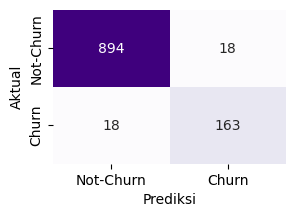

In [ ]:
# Classification Report pada Kondisi Threshold Normal (0.5)
from sklearn.metrics import classification_report, recall_score, fbeta_score

y_pred = pipe_model.predict(x_test)
print(classification_report(y_test, y_pred))
print('recall score :', round(recall_score(y_test, y_pred),3))
f2_score = fbeta_score(y_test, y_pred, beta=2)
print(f'f2 score : {f2_score:.3f}')


# Heatmap Confusion Matrix pada threshold 0.5
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(3,2))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True, fmt='.0f', cmap='Purples', cbar=False,
    xticklabels=['Not-Churn', 'Churn'],  # Ubah label sumbu X
    yticklabels=['Not-Churn', 'Churn']   # Ubah label sumbu Y
)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

**Evaluasi Kinerja Model XGBoost pada Threshold Default**

Model ini menunjukkan performa yang sangat baik dengan **F2 score sebesar 0.901** dan **akurasi 0.97**. Nilai *precision* dan *recall* pada kelas *churn* yang sama-sama 0.90 menandakan model cukup seimbang dalam mendeteksi pelanggan *churn* tanpa banyak menghasilkan kesalahan prediksi.

* ***True Positive* (TP) = 163**
  Artinya, sebanyak 163 pelanggan *churn* berhasil diprediksi dengan benar sebagai *churn*. Ini menunjukkan model cukup baik dalam mendeteksi pelanggan yang benar-benar berisiko *churn*.

* ***True Negative* (TN) = 894**
  Sebanyak 894 pelanggan yang tidak *churn* juga berhasil diprediksi dengan benar sebagai tidak *churn*. Ini menandakan model efektif dalam mengenali pelanggan yang loyal.

* ***False Positive* (FP) = 18**
  Ada 18 pelanggan yang sebenarnya tidak *churn*, tetapi model salah memprediksi sebagai *churn*. Hal ini dapat menyebabkan intervensi retensi yang tidak perlu pada pelanggan loyal, namun jumlahnya masih tergolong rendah.

* ***False Negative* (FN) = 18**
  Sebanyak 18 pelanggan *churn* gagal terdeteksi oleh model. Pelanggan-pelanggan ini berisiko tidak mendapatkan upaya retensi, tetapi jumlahnya sudah cukup minimal jika dibandingkan total pelanggan *churn*.



### **4.3.3 Penentuan Threshold Optimal Berdasarkan F2-score**

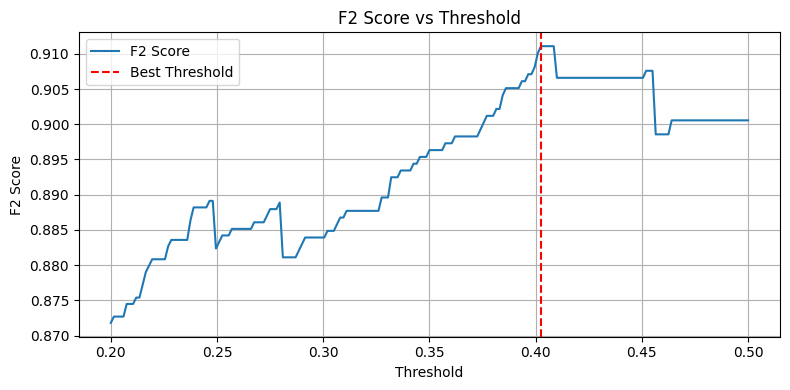

,threshold,f2
0,0.404,0.911087


In [ ]:
# Menentukan threshold dan menghitung F2-score
list_threshold = np.linspace(0.2, 0.5, 201)
list_f2 = []

for threshold in list_threshold:
    y_probs = pipe_model.predict_proba(x_test)[:, 1]
    y_pred_new = (y_probs >= threshold).astype(int)
    f2 = fbeta_score(y_test, y_pred_new, beta=2)
    list_f2.append(f2)

# Buat DataFrame
df_threshold = pd.DataFrame({
    'threshold': list_threshold,
    'f2': list_f2,
})

# Plot sebelum disorting
plt.figure(figsize=(8, 4))
plt.plot(df_threshold['threshold'], df_threshold['f2'], label='F2 Score')
plt.axvline(x=df_threshold.loc[df_threshold['f2'].idxmax(), 'threshold'], color='red', linestyle='--', label='Best Threshold')
plt.title('F2 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F2 Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Ambil threshold terbaik
df_threshold = df_threshold.sort_values(by='f2', ascending=False).reset_index(drop=True)
threshold = df_threshold['threshold'][0]
df_threshold.head(1)


### **4.3.4 Evaluasi Model pada Threshold Optimal**

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       912
           1       0.89      0.92      0.90       181

    accuracy                           0.97      1093
   macro avg       0.94      0.95      0.94      1093
weighted avg       0.97      0.97      0.97      1093

recall score : 0.917
f2 score : 0.911


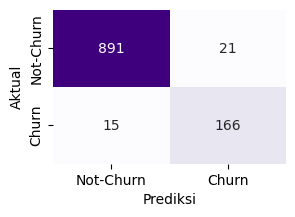

In [ ]:
# Mengubah Threshold untuk mendapat nilai F2 optimum
y_probs = pipe_model.predict_proba(x_test)[:,1]
y_pred_new = (y_probs >= threshold).astype(int)

# Classification Report Setelah Menurunkan Threshold Probability
print(classification_report(y_test, y_pred_new))
print(f'recall score : {recall_score(y_test, y_pred_new):.3f}')
f2_score = fbeta_score(y_test, y_pred_new, beta=2)
print(f'f2 score : {f2_score:.3f}')

# Heatmap Confusion Matrix
plt.figure(figsize=(3,2))
sns.heatmap(
    confusion_matrix(y_test, y_pred_new),
    annot=True, fmt='.0f', cmap='Purples', cbar=False,
    xticklabels=['Not-Churn', 'Churn'],  # Ubah label sumbu X
    yticklabels=['Not-Churn', 'Churn']   # Ubah label sumbu Y
)
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

| Parameter         | Threshold 0.5 | Threshold Optimum |
|-------------------|---------------|-------------------|
| F2 Score          | 0.901         | 0.911             |
| Precision (Churn) | 0.90          | 0.89              |
| Recall (Churn)    | 0.90          | 0.92              |
| Accuracy          | 0.97          | 0.97              |
| TP (Churn)        | 163           | 166               |
| TN (Not Churn)    | 894           | 891               |
| FP                | 18            | 21                |
| FN                | 18            | 15                |


Perbandingan antara *threshold* 0.5 dan *threshold* optimum menunjukkan bahwa *threshold* optimum mampu meningkatkan F2 score dari 0.901 menjadi 0.911 serta menurunkan jumlah *false negative* dari 18 menjadi 15. Artinya, semakin banyak pelanggan *churn* yang berhasil terdeteksi tanpa penurunan akurasi yang berarti. Walaupun terjadi sedikit kenaikan *false positive*, peningkatan recall dan penurunan *false negative* ini sangat penting dalam konteks deteksi *churn*, sehingga *threshold* optimum lebih direkomendasikan untuk memaksimalkan upaya retensi pelanggan.


### **4.3.5 Evaluasi Kurva ROC dan Precision-Recall**

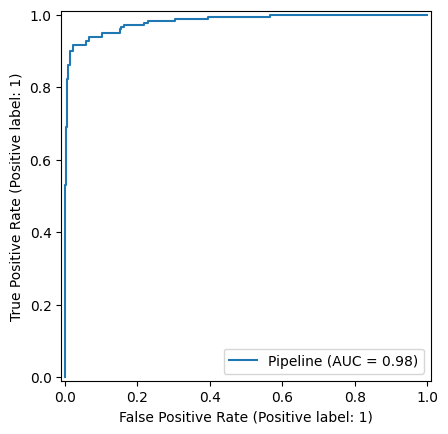

In [ ]:
from sklearn.metrics import RocCurveDisplay
roc_curve = RocCurveDisplay.from_estimator(pipe_model, x_test, y_test)

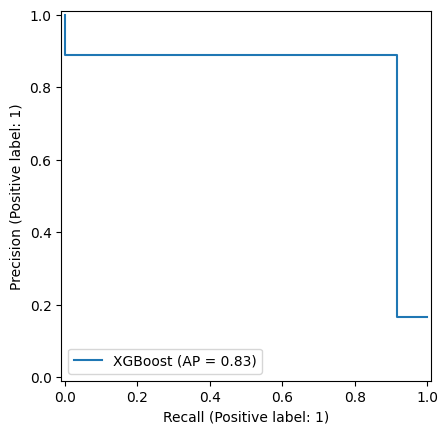

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
disp = PrecisionRecallDisplay.from_predictions(y_test, y_pred_new, name="XGBoost")

**1. ROC Curve**


* Nilai AUC sebesar **0.98** menunjukkan bahwa model memiliki **kemampuan klasifikasi yang sangat baik** untuk membedakan antara pelanggan yang churn dan tidak churn.
* Kurva yang mendekati sudut kiri atas menandakan bahwa model menghasilkan **tingkat *false positive* yang rendah dan *true positive* yang tinggi** secara bersamaan.


**2. Precision-Recall Curve**


* Kurva menunjukkan hubungan antara **kemampuan model dalam mendeteksi *churn* (*recall*)** dan **akurasi dari prediksi *churn* yang diberikan (*precision*)**.
* Nilai ***Average Precision* sebesar 0.82** mengindikasikan bahwa model **konsisten memberikan prediksi *churn* yang cukup andal**, meskipun ketidakseimbangan kelas (jumlah pelanggan churn yang sedikit) dapat mempengaruhi *precision* saat *recall* tinggi.
* Bentuk kurva yang awalnya tinggi dan stabil menunjukkan model memiliki **kemampuan yang baik dalam mengidentifikasi pelanggan *churn* dengan presisi tinggi** pada level *recall* yang moderat.



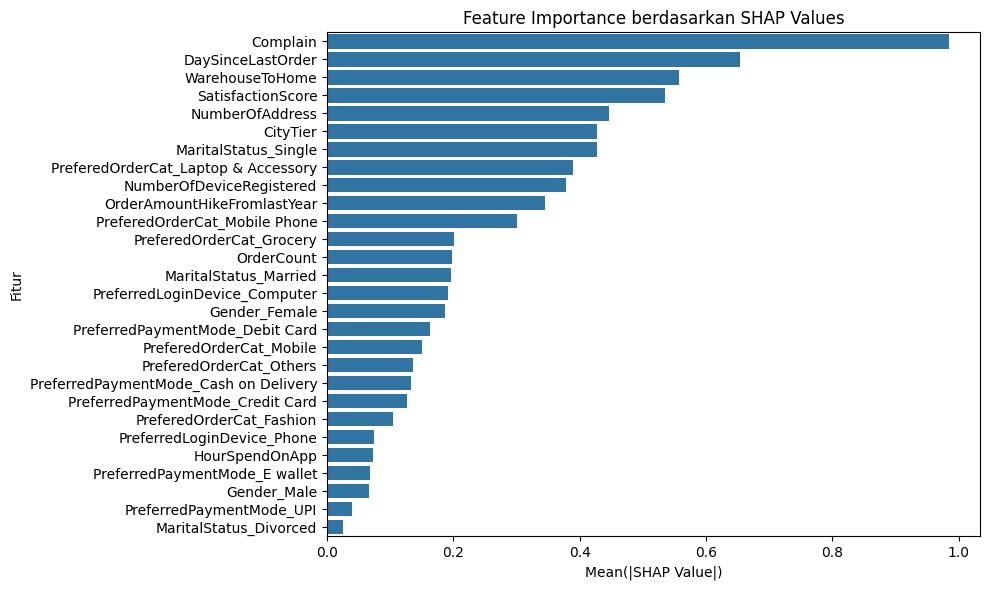

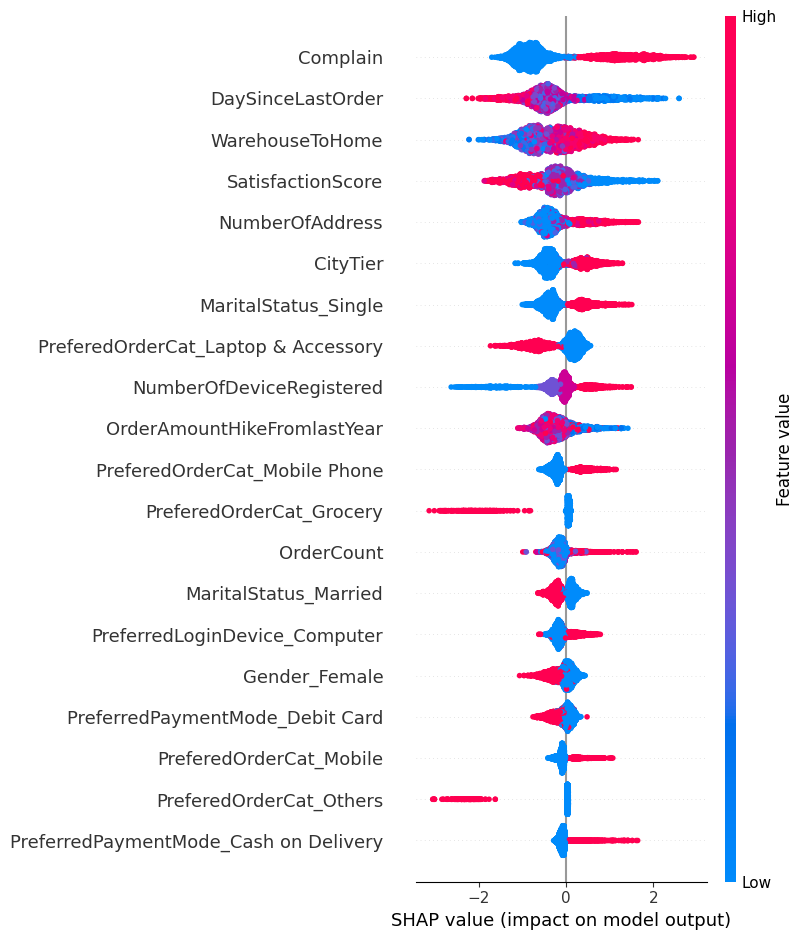

In [ ]:
def get_custom_feature_names(transformer, x_df):
    feature_names = []
    passthrough_cols = []

    for name, trans, cols in transformer.transformers_:
        if trans == 'drop':
            continue
        elif name == 'remainder':
            # Ini adalah fitur yang di-passthrough
            passthrough_cols = cols  # biasanya berupa indeks jika tidak diberi nama eksplisit
            continue

        if isinstance(trans, Pipeline):
            last_step = trans.steps[-1][1]
            if isinstance(last_step, FunctionTransformer):
                feature_names.append(f"{cols[0]}_bin")
            else:
                feature_names.extend(cols)

        elif isinstance(trans, OneHotEncoder):
            ohe_names = trans.get_feature_names_out(cols)
            feature_names.extend(ohe_names)

        else:
            feature_names.extend(cols)

    # Tambahkan nama kolom yang di-passthrough
    if passthrough_cols is None or isinstance(passthrough_cols[0], int):
        # Jika berbentuk indeks, konversi ke nama kolom asli
        passthrough_cols = x_df.columns[passthrough_cols]

    feature_names.extend(passthrough_cols)
    return feature_names

X_train_transformed = pipe_model.named_steps['transformer'].transform(x_train)
if issparse(X_train_transformed):
    X_train_transformed = X_train_transformed.toarray()

feature_names = get_custom_feature_names(pipe_model.named_steps['transformer'], x_train)
assert X_train_transformed.shape[1] == len(feature_names), "❌ Jumlah fitur tidak cocok!"

X_train_df = pd.DataFrame(X_train_transformed, columns=feature_names)

explainer = shap.TreeExplainer(pipe_model.named_steps['model'])
shap_values = explainer.shap_values(X_train_df)

mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_abs_shap
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=shap_df)
plt.title('Feature Importance berdasarkan SHAP Values')
plt.xlabel('Mean(|SHAP Value|)')
plt.ylabel('Fitur')
plt.tight_layout()
plt.show()

shap.summary_plot(shap_values, X_train_df)

###**4.3.6 Analisis Interpretabilitas Model dengan SHAP**

* **Sumbu Y (fitur)**: Urutan fitur berdasarkan pengaruh terhadap prediksi *churn* (atas = paling penting).
* **Sumbu X (SHAP value)**: Besarnya pengaruh terhadap prediksi.

  * SHAP positif (kanan): cenderung meningkatkan risiko *churn*.
  * SHAP negatif (kiri): cenderung menurunkan risiko *churn*.
* **Warna**: Merah (nilai fitur tinggi), Biru (nilai fitur rendah).



**Hasil Interpretasi:**

1. **Complain**

   * Pelanggan yang pernah komplain (merah) cenderung *churn*.

2. **DaySinceLastOrder**

   * Semakin baru pelanggan memesan (biru), semakin besar kemungkinan *churn*. Sebaliknya, semakin lama tidak memesan (merah), semakin kecil risiko *churn*.

3. **WarehouseToHome**

   * Jarak lebih jauh (merah) berkontribusi terhadap peningkatan *churn*, tetapi pengaruhnya bervariasi.

4. **SatisfactionScore**

   * Pelanggan dengan tingkat kepuasan tinggi (merah) cenderung bertahan, sedangkan rendah (biru) cenderung *churn*.

5. **NumberOfAddress**

   * Semakin banyak alamat pelanggan (merah), risiko *churn* sedikit meningkat.

6. **CityTier**

   * Pelanggan dari tier kota lebih tinggi (merah) cenderung memiliki risiko *churn* sedikit lebih rendah.

7. **MaritalStatus_Single**

   * Pelanggan single (merah) cenderung lebih berisiko *churn* dibandingkan yang tidak single.




##**4.4 Kesimpulan Kinerja Model Skenario 3: Tanpa Fitur Tidak Aman dan Fitur yang Berisiko**

Model menunjukkan performa yang sangat tinggi dengan **F2 score 0.911** dan **AUC 0.98**, menandakan kemampuan deteksi *churn* yang sangat baik. Seluruh fitur yang digunakan pada model ini telah dipastikan **tidak mengandung fitur tidak aman maupun fitur yang berisiko *leakage***, sehingga hasil evaluasi sudah mencerminkan kondisi prediksi saat deployment secara nyata.
**Fitur tidak aman seperti `tenure` serta fitur yang berisiko *leakage* seperti `coupon used` dan `cashbackamount` telah di-drop dari data pelatihan**, sehingga model benar-benar hanya menggunakan fitur yang aman.

Dari *confusion matrix*, diperoleh:

* ***True Positive* (TP) = 166**: Pelanggan *churn* yang berhasil diprediksi dengan benar sebagai *churn*.
* ***True Negative* (TN) = 891**: Pelanggan tidak *churn* yang berhasil dikenali sebagai tidak *churn*.
* ***False Positive* (FP) = 21**: Pelanggan yang tidak *churn* tetapi salah diprediksi sebagai *churn*, yang berpotensi menyebabkan intervensi yang tidak perlu.
* ***False Negative* (FN) = 15**: Pelanggan *churn* yang gagal terdeteksi, berisiko kehilangan pelanggan tanpa upaya retensi.

Nilai FN yang rendah dan TP yang tinggi menunjukkan kemampuan deteksi *churn* yang sangat kuat, dan model ini sudah dapat diandalkan untuk kebutuhan prediksi *churn* pada data nyata.


##**4.5 Save Model 3 dengan Pickle**

| Skenario                                   | F2 Score | Recall (Churn) | Precision (Churn) | TP  | TN  | FP  | FN  |
|---------------------------------------------|----------|----------------|-------------------|-----|-----|-----|-----|
| Tanpa drop fitur                           | 0.920    | 0.94           | 0.83              | 171 | 878 | 34  | 10  |
| Drop fitur tidak aman                      | 0.911    | 0.91           | 0.91              | 165 | 895 | 17  | 16  |
| Drop fitur tidak aman dan fitur berisiko    | 0.911    | 0.92           | 0.89              | 166 | 891 | 21  | 15  |


Berdasarkan hasil komparasi, **model pada skenario 3** (*drop* fitur tidak aman dan fitur berisiko) dipilih karena sudah sepenuhnya menggunakan fitur yang aman dan bebas dari risiko *data leakage*. Meskipun F2 score-nya sedikit lebih rendah dibandingkan skenario tanpa *drop* fitur, performa *recall* dan *precision* tetap sangat baik, dan jumlah FN serta FP masih rendah. Dengan demikian, model ini lebih dapat diandalkan untuk prediksi *churn* di dunia nyata karena hasil evaluasinya sudah mencerminkan situasi *deployment* yang sebenarnya tanpa ketergantungan pada fitur berisiko.


In [ ]:
# 1. Definisi Global
df['Churn'] = df['Churn'].astype(int)
X = df.drop(['Churn', 'Tenure', 'CashbackAmount', 'CouponUsed'], axis=1)
y = df['Churn']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020, stratify=y)

class OptBinningTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, splits):
        self.splits = splits

    def fit(self, X, y=None):
        # Sudah fit splits di luar
        return self

    def transform(self, X):
        X_ = np.asarray(X)
        if X_.ndim == 1:
            X_ = X_.reshape(-1, 1)
        vals = X_[:, 0]
        return np.digitize(vals, bins=self.splits).reshape(-1, 1)


impute_cols = [
    'OrderAmountHikeFromlastYear',
    'OrderCount', 'DaySinceLastOrder'
]

binning_cols = [
    'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered',
    'NumberOfAddress', 'OrderAmountHikeFromlastYear',
    'OrderCount', 'DaySinceLastOrder'
]

categorical_cols = [
    'PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus'
]
ordinal_cols = ['CityTier', 'SatisfactionScore']

num_transformers = []

for col in binning_cols:
    steps = []
    # Jika butuh imputasi
    if col in impute_cols:
        imputer = IterativeImputer(
            estimator=XGBRegressor(n_estimators=100, max_depth=3, verbosity=0, random_state=42),
            max_iter=10, random_state=0
        )
        # Fit dulu untuk dapetin data imputasi training
        imputed_train_col = imputer.fit_transform(x_train[[col]])
        train_col_data = pd.Series(imputed_train_col.ravel())
    else:
        train_col_data = x_train[col]
        imputer = None

    # Fit OptBinning hanya di training
    binning = OptimalBinning(name=col, dtype="numerical")
    binning.fit(train_col_data.values, y_train)
    splits = binning.splits

    # Siapkan pipeline steps
    if imputer is not None:
        steps.append(('imputer', imputer))
    steps.append(('binning', OptBinningTransformer(splits)))
    col_pipe = Pipeline(steps)
    num_transformers.append((f'{col}_pipe', col_pipe, [col]))

cat_transformer = ('cat_ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols)
ord_transformer = ('ord_enc', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_cols)

transformer = ColumnTransformer(
    transformers=num_transformers + [cat_transformer, ord_transformer],
    remainder='passthrough'
)

transformer.fit(x_train)

# 6. Model & Pipeline Akhir
model = XGBClassifier(random_state=500, scale_pos_weight=np.sum(y_train==0)/np.sum(y_train==1), use_label_encoder=False, eval_metric='logloss')
pipe_model3 = Imbpipeline([
    ('transformer', transformer),
    ('model', model)
])

best_params = {'model__colsample_bytree': np.float64(0.7042853199679666), 'model__gamma': np.float64(0.3462715314292997), 'model__learning_rate': np.float64(0.1059826518075929), 'model__max_depth': 9, 'model__min_child_weight': 2, 'model__n_estimators': 365, 'model__subsample': np.float64(0.9194856766618298)}

pipe_model3 = pipe_model3.set_params(**best_params)
pipe_model3.fit(x_train, y_train)

# 7. Simpan pipeline ke file pickle

with open('xgb_model_skenario3.pkl', 'wb') as f:
    pickle.dump(pipe_model3, f)


#**5. Kesimpulan**

##**5.1. Performa Model**

Model XGBoost telah dievaluasi menggunakan *threshold* optimal sebesar 0.404, yang diperoleh melalui optimasi F2-score. Selain itu, fitur-fitur yang berpotensi menyebabkan kebocoran data seperti `Tenure`, `CashbackAmount`, dan `CouponUsed` telah dihapus untuk memastikan integritas prediksi.

Hasil evaluasi menunjukkan bahwa model mampu mengidentifikasi pelanggan *churn* secara efektif dengan **F2-score sebesar 0.911** dan **recall *churn* mencapai 92%**. Akurasi keseluruhan model berada pada tingkat 97%, dengan distribusi prediksi sebagai berikut:

* **True Positive (TP = 166):** Pelanggan *churn* yang berhasil diprediksi dengan benar.
* **False Positive (FP = 21):** Pelanggan tidak *churn* yang salah diprediksi akan *churn*.
* **False Negative (FN = 15):** Pelanggan *churn* yang tidak berhasil terdeteksi oleh model.
* **True Negative (TN = 891):** Pelanggan tidak *churn* yang diprediksi dengan benar.

Dengan jumlah false negative yang rendah, model ini sangat sesuai untuk mendukung strategi retensi pelanggan melalui deteksi dini terhadap risiko *churn*. Penghapusan fitur yang tidak aman juga menjadikan model ini siap digunakan dalam sistem produksi secara bertanggung jawab dan bebas dari risiko kebocoran data.


##**5.2. Batasan Model**

### **5.2.1. Batasan Interval Pada Feature Numerik**

Berdasarkan hasil statistik deskriptif dari dataset, berikut adalah rentang nilai yang diperbolehkan untuk setiap fitur:

* **WarehouseToHome**:

  * Rentang yang disarankan: **5 hingga 36** km
    (nilai di atas 36 km di luar cakupan data historis)

* **HourSpendOnApp**:

  * Rentang yang disarankan: **0 hingga 4** jam
    (rentang sudah ideal, tidak perlu penyesuaian)

* **NumberOfDeviceRegistered**:

  * Rentang yang disarankan: **1 hingga 6** perangkat
    (rentang logis dan sesuai dengan distribusi)

* **NumberOfAddress**:

  * Rentang yang disarankan: **1 hingga 20** alamat
    (di atas 20 alamat termasuk sangat jarang terjadi dan perlu diwaspadai)

* **OrderAmountHikeFromlastYear**:

  * Rentang yang disarankan: **11 hingga 26**
    (nilai >26 dianggap anomali)

* **OrderCount**:

  * Rentang yang disarankan: **1 hingga 16** pesanan
    (nilai di atas 16 dapat dianggap anomali)

* **DaySinceLastOrder**:

  * Rentang yang disarankan: **0 hingga 18** hari
    (di atas 18 hari tidak umum dalam siklus aktif pelanggan)

Dengan menetapkan batasan ini, sistem dapat menghindari potensi kesalahan akibat nilai ekstrim yang tidak wajar atau di luar cakupan historis.


###**5.2.2 Identifikasi Fitur Berpotensi Leakage hanya Berbasis WOE dan IV**

Identifikasi fitur yang berpotensi menyebabkan ***data leakage*** dalam model ini **tidak didasarkan pada urutan waktu secara eksplisit**, melainkan melalui analisis **Weight of Evidence (WOE)** dan **Information Value (IV)**. Berdasarkan hasil analisis, fitur diklasifikasikan sebagai berikut:

* **Fitur Tidak Aman**:

  * `Tenure`
    Memiliki nilai IV sebesar 1.759 yang sangat tinggi, serta WoE ekstrem pada beberapa bin, menandakan potensi kuat terjadinya *target leakage*.

* **Fitur Berisiko**:

  * `CashbackAmount`
    Memiliki bin dengan WoE sebesar +1.99, yang menunjukkan distribusi target sangat timpang.
  * `CouponUsed`
    Memiliki WoE sebesar +2.09 pada bin "Missing", yang mengindikasikan ketidakseimbangan informasi yang perlu dikonfirmasi dan diselidiki lebih lanjut.

* **Fitur Aman**:

  * `WarehouseToHome`
  * `HourSpendOnApp`
  * `NumberOfDeviceRegistered`
  * `NumberOfAddress`
  * `OrderAmountHikeFromlastYear`
  * `OrderCount`
  * `DaySinceLastOrder`

Pendekatan ini membantu menjaga keakuratan model tanpa mengandalkan informasi masa depan yang tidak tersedia saat prediksi aktual dilakukan.



## **5.3. Interpretasi Bisnis**

**Asumsi**

* **Biaya promosi per pelanggan**: Rp100.000
* **Total pelanggan**: 891 (TN) + 21 (FP) + 15 (FN) + 166 (TP) = **1.093 pelanggan**
* **Jumlah pelanggan yang diprediksi *churn* oleh model**: 21 (FP) + 166 (TP) = **187 pelanggan**
* **Jumlah pelanggan benar-benar *churn* dalam prediksi tersebut**: **166 pelanggan**

---

**Skenario 1 – Promosi Tanpa Model (Semua Diberi Kupon)**

Semua pelanggan diberikan promosi tanpa melihat risiko *churn*:

* **Biaya promosi total**:
  1.093 × Rp100.000 = **Rp109.300.000**

---

**Skenario 2 – Promosi Berdasarkan Model**

Hanya pelanggan yang diprediksi akan *churn* oleh model yang diberikan promosi (187 orang):

* **Biaya promosi total**:
  187 × Rp100.000 = **Rp18.700.000**

---

**Efisiensi Biaya Promosi**

* **Penghematan**:
  Rp109.300.000 − Rp18.700.000 = **Rp90.600.000**

* **Efisiensi (%)**:
  (90.600.000 / 109.300.000) × 100 = **82,89%**

---

Dengan menggunakan model prediktif untuk menargetkan pelanggan yang benar-benar berisiko *churn*, perusahaan dapat:

* Menghemat biaya promosi hingga **Rp90,6 juta**
* Meningkatkan efisiensi anggaran hingga **82,89%**
* Tetap mempertahankan 166 pelanggan *churn* secara tepat sasaran

Model terbukti membantu dalam mengalokasikan sumber daya promosi secara jauh lebih efektif.


## **5.4. Insight Berdasarkan Analisis Data (EDA)**

1. **Tingkatkan personalisasi *user***
   Personalisasi penggunaan app dan situs *e-commerce* merupakan hal yang harus dituju. Personalisasi dalam arti kemudahan pelanggan menggunakan *platform e-commerce* bisa berupa UI yang terstruktur rapi, termasuk font yang cukup besar untuk *mobile app*. Menyederhanakan registrasi perangkat seperti memberi opsi akun bersama atau *parental control* juga penting demi keamanan dan kemudahan interaksi awal pelanggan dengan *e-commerce*. Tawaran diskon atau *bundle* yang relevan, algoritma yang mengutamakan preferensi pelanggan berdasarkan sejarah *browsing*, serta fitur *eye-tracking*, dapat meningkatkan pengalaman pengguna. Semakin sering pelanggan menemukan apa yang mereka cari di *platform e-commerce*, semakin besar kemungkinan mereka untuk kembali dan melakukan *subscribe*.

2. **Optimalisasikan sistem pengiriman**
   Pelanggan yang *churn* cenderung berada pada jarak pengiriman barang yang jauh, khususnya pada kisaran 27.5–31.5 km dari gudang *e-commerce*. Perusahaan dapat fokus pada sistem pengiriman yang transparan, misalnya informasi *shipping* yang selalu ter-update dan kompensasi apabila terjadi masalah dari pihak kurir. Menawarkan *express delivery* dengan harga terjangkau dapat mengurangi kecenderungan *churn* pada pelanggan dengan jarak pengiriman jauh.

3. **Optimalisasi dan diversifikasi metode pembayaran**
   Churn juga tinggi pada pelanggan yang menggunakan metode pembayaran *UPI*, yaitu metode eksternal di luar *platform e-commerce*. *E-commerce* dapat memperluas opsi pembayaran yang aman di dalam *platform*, sehingga pelanggan merasa puas dengan pilihan yang tersedia. Implementasi ‘*3 step verification*’ juga dapat meningkatkan rasa aman dalam bertransaksi.

4. **Memperjelas target segmentasi *e-commerce***
   Ditemukan bahwa pelanggan yang *churn* banyak terdapat pada kategori produk elektronik dan *fashion*. Retensi awal di segmen ini sulit karena pelanggan cenderung impulsif dan tidak setia pada satu atau dua *platform shopping* saja. Menawarkan *free delivery* berdasarkan jumlah order dapat menjadi insentif bagi mereka untuk pembelian lebih banyak. Perusahaan bisa memprioritaskan produk-produk aksesoris elektronik (seperti *headphone*, *casing smartphone*/*tablet*, *powerbank*) yang lebih fleksibel dari sisi harga. Selain itu, implementasi *CTR* (*Click-Through Rate*) dapat digunakan untuk mengukur ketertarikan pelanggan wanita pada kategori *fashion*, sehingga algoritma bisa diarahkan untuk mengenali produk busana yang menarik pada segmen tersebut.

5. **Implementasi *survey feedback* yang informatif dan interaktif**
   Pelanggan yang melakukan *complain* memiliki risiko *churn* tiga kali lipat dibandingkan pelanggan lain. *Survey* tipe Likert bisa diterapkan untuk mengukur kepuasan dalam proses registrasi perangkat atau layanan lainnya, sehingga perusahaan mendapat masukan yang lebih spesifik. Penyediaan *chatbot AI* dan *customer service* dapat menjadi bentuk pendekatan instan dan responsif kepada pelanggan.


#**6. Saran**

Pada dataset ini terdapat sejumlah fitur yang berpotensi menyebabkan ***data leakage***, yaitu kondisi di mana model belajar dari informasi yang seharusnya tidak tersedia pada saat prediksi dilakukan. Fitur-fitur tersebut antara lain:

1. **Tenure**
   Menunjukkan lamanya pelanggan bertahan hingga saat ini. Nilai ini bisa mencerminkan kondisi “akhir”, terutama jika dihitung saat atau setelah pelanggan *churn*.

2. **CashbackAmount**
   Total *cashback* yang diterima pelanggan. Jika tercatat setelah pelanggan menunjukkan gejala *churn* atau diberikan sebagai bentuk retensi terakhir, maka dapat memuat informasi pasca-*churn*.

3. **CouponUsed**
   Jumlah kupon yang telah digunakan. Jika penggunaan kupon terjadi mendekati atau setelah perilaku *churn*, fitur ini dapat merefleksikan intervensi pasca-*churn*.

4. **OrderAmountHikeFromlastYear**
   Persentase kenaikan jumlah pesanan dari tahun sebelumnya. Nilai ini sangat mungkin menggambarkan pola konsumsi akhir yang terbentuk menjelang *churn*, bukan sinyal awal.

5. **OrderCount**
   Jumlah pesanan kumulatif. Jika tidak dibatasi pada periode tertentu sebelum *churn*, fitur ini bisa mencerminkan perilaku pelanggan di saat mendekati atau bahkan setelah *churn*.

6. **DaySinceLastOrder**
   Jumlah hari sejak pesanan terakhir. Jika dihitung dari waktu referensi yang sudah melampaui titik *churn*, maka nilai ini secara langsung menunjukkan bahwa pelanggan sudah tidak aktif.

Fitur-fitur di atas **harus dikonfirmasi apakah nilainya tersedia sebelum *churn* terjadi atau justru setelahnya**. Untuk mengonfirmasi hal ini secara akurat, **diperlukan data tambahan berupa *timestamp* atau *snapshot* waktu** yang menunjukkan kapan tepatnya setiap nilai fitur dicatat. Tanpa adanya informasi waktu yang memadai, sulit untuk memastikan apakah fitur tersebut benar-benar aman digunakan dalam prediksi prospektif.